In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = '/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data'

train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

print(train_path)
print(test_path)

/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/train.csv
/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/test.csv


In [3]:
train_data = pd.read_csv(train_path) # ----- (1)
sub_data = pd.read_csv(test_path) # -----(2)

print(f"train data dim: {train_data.shape}")
print(train_data.info())

print(f"\nsub data dim:   {sub_data.shape}")
print(sub_data.info())

train data dim: (15035, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 n

In [4]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
train_data_corr = train_data.corr()
train_data_corr

id     price  ...  sqft_living15  sqft_lot15
id             1.000000  0.020899  ...       0.029248   -0.032269
price          0.020899  1.000000  ...       0.586419    0.086384
bedrooms       0.010520  0.323672  ...       0.407394    0.027242
bathrooms      0.104030  0.525479  ...       0.573541    0.088120
sqft_living    0.041725  0.702899  ...       0.760271    0.184176
sqft_lot      -0.034077  0.096793  ...       0.147562    0.728458
floors         0.182848  0.262588  ...       0.287125   -0.010287
waterfront    -0.011775  0.265738  ...       0.091810    0.028255
view          -0.024360  0.400806  ...       0.278267    0.076501
condition     -0.101618  0.039740  ...      -0.091407   -0.003873
grade          0.078622  0.667211  ...       0.715321    0.119734
sqft_above     0.073086  0.608577  ...       0.737795    0.194226
sqft_basement -0.050634  0.322218  ...       0.198380    0.018813
yr_built       0.202477  0.047290  ...       0.324221    0.076009
yr_renovated  -0.029810  0.140808  ...       0.007995   -0.000348
zipcode       -0.005761 -0.051498  ...      -0.274176   -0.145710
lat            0.002588  0.301604  ...       0.048924   -0.081725
long           0.014757  0.023547  ...       0.333673    0.256201
sqft_living15  0.029248  0.586419  ...       1.000000    0.183599
sqft_lot15    -0.032269  0.086384  ...       0.183599    1.000000

[20 rows x 20 columns]

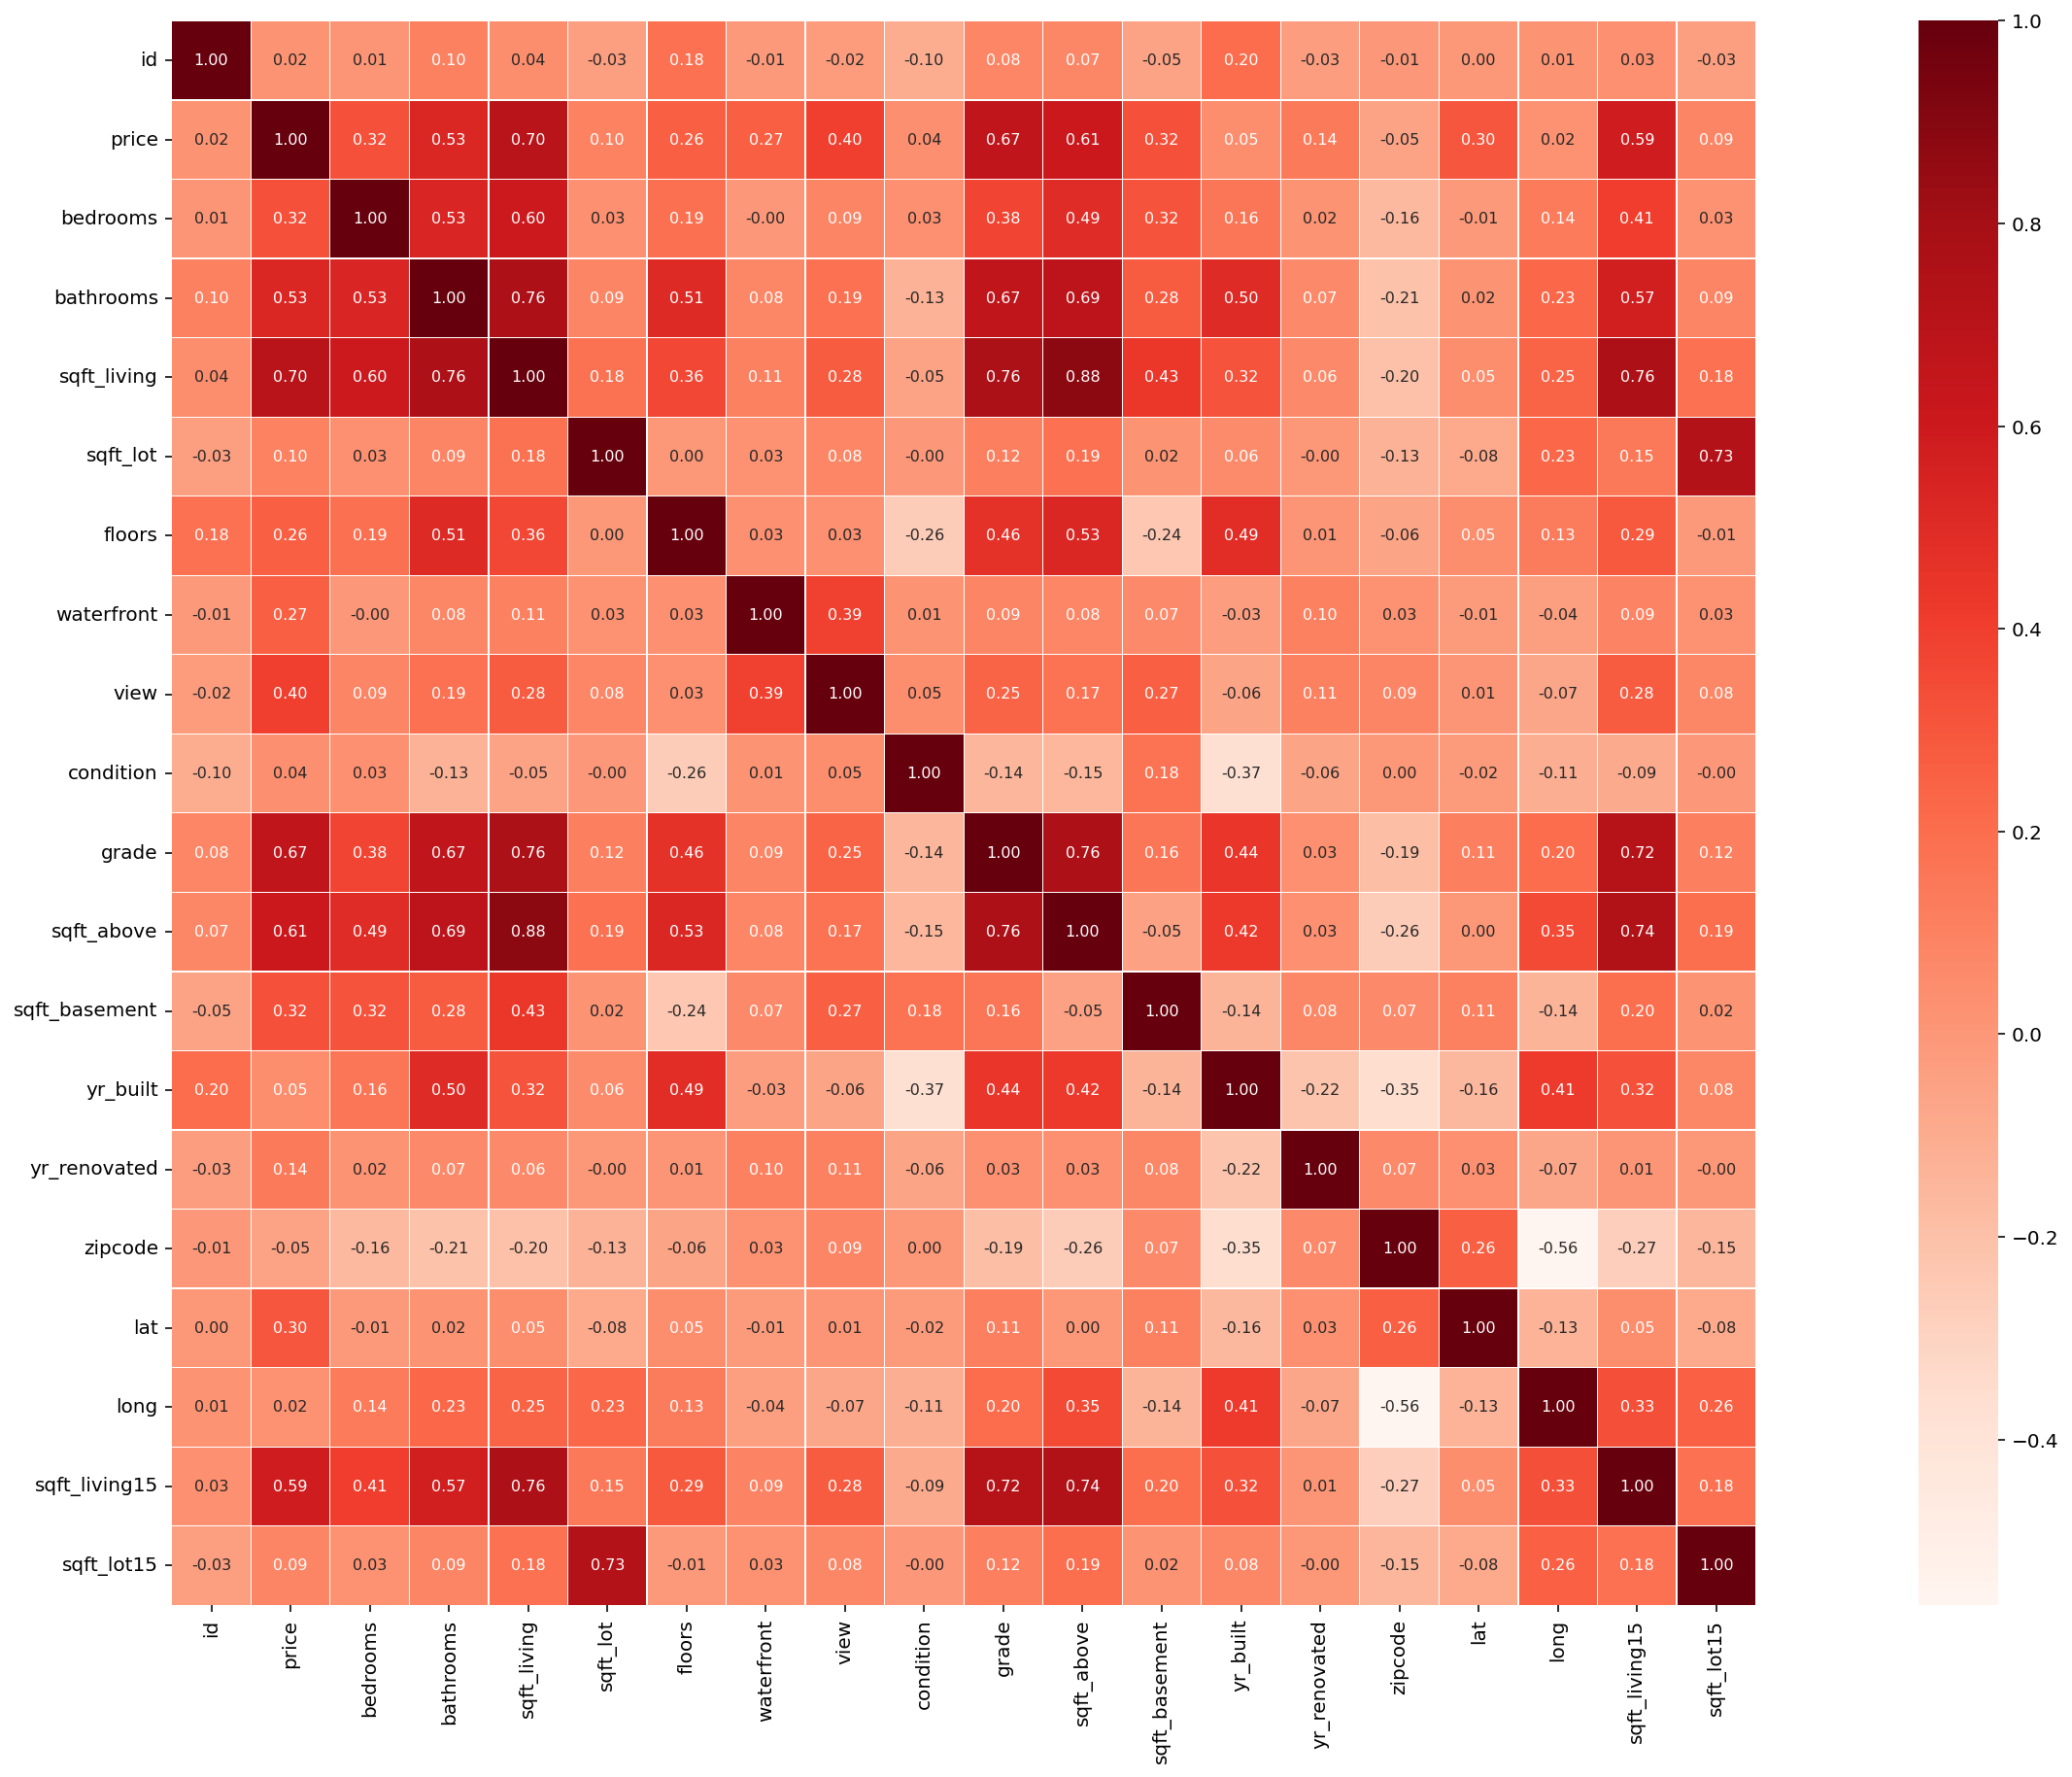

In [6]:
plt.figure(figsize = (30,15))
sns.heatmap(train_data_corr,
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = plt.cm.Reds,
            linecolor = "white",
            fmt = '.2f',
            annot = True,
            annot_kws = {"size" : 8})

- price / sqft_living (0.7)
  - 주거 공간과 금액의 상관관계
- sqft_above / sqft_living (0.88)
  - 주거 공간의 평방 피트와 주거 공간의 평방 피트 상관관계
- sqft_living / bathrooms (0.75)
  - 주거 공간의 평방 피트와 화장실 수의 상관관계
- grade / sqft_living (0.76)
  - 집의 등급과 주거 공간의 평방 피트 상관관계
- sqft_living15 / sqft_living (0.76)
  - 2015년 기준 부지의 평방 피트와 주거 공간의 평방 피트 상관관계
- sqft_lot15 / sqft_lot (0.72)
  - 2015년 기준 부지의 평방피트와 부지의 평방 피트 상관관계
- sqft_living15 / grade (0.71)
 - 2015년 기준 주거 공간의 평방 피트 와 집의 등급의 상관관계
- sqft_living15 / sqft_above (0.73)
  - 2015년 지군 주거 공간의 평방 피트와 지하실을 제외한 평방 피트 상관관계


> - sqft_living15: 2015년 기준 주거 공간의 평방 피트
- sqft_lot15: 2015년 기준 부지의 평방 피트
- sqft_above: 지하실을 제외한 평방 피트
- sqft_lot: 부지의 평방 피트(면적)
- sqft_living: 주거 공간의 평방 피트(면적)
- bathrooms: 화장실의 수
- grade: King County grading 시스템 기준으로 매긴 집의 등급

In [7]:
train_data_corr["price"].sort_values(ascending = False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
zipcode         -0.051498
Name: price, dtype: float64

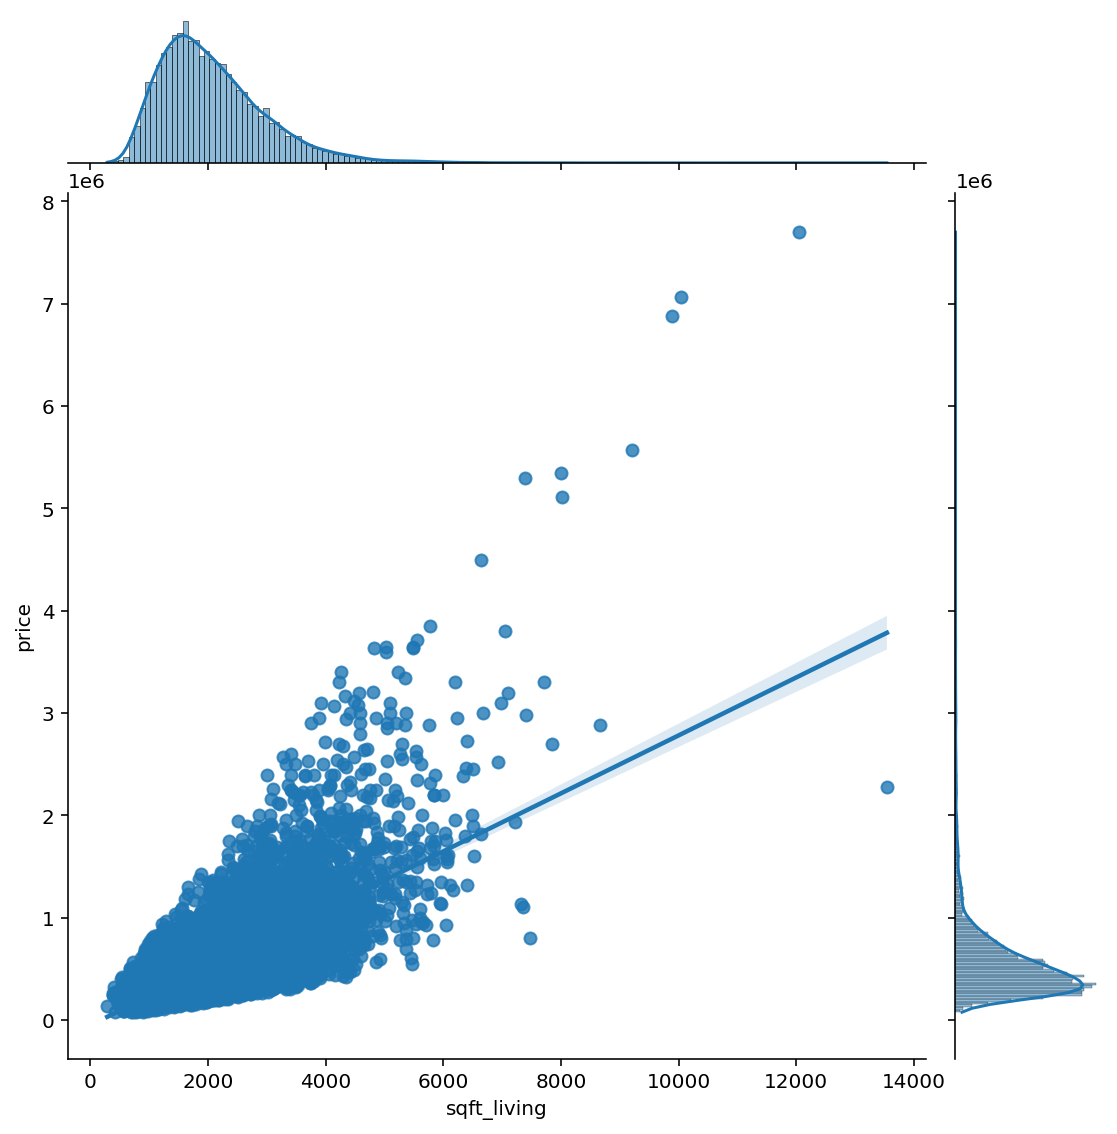

In [8]:
sns.jointplot('sqft_living', 'price', 
              height = 8,
              data = train_data,
              kind = 'reg')

In [9]:
train_data.loc[(train_data['sqft_living'] > 13000) & (train_data['price'] > 2000000)]
train_data = train_data.loc[train_data['id'] != 8912]

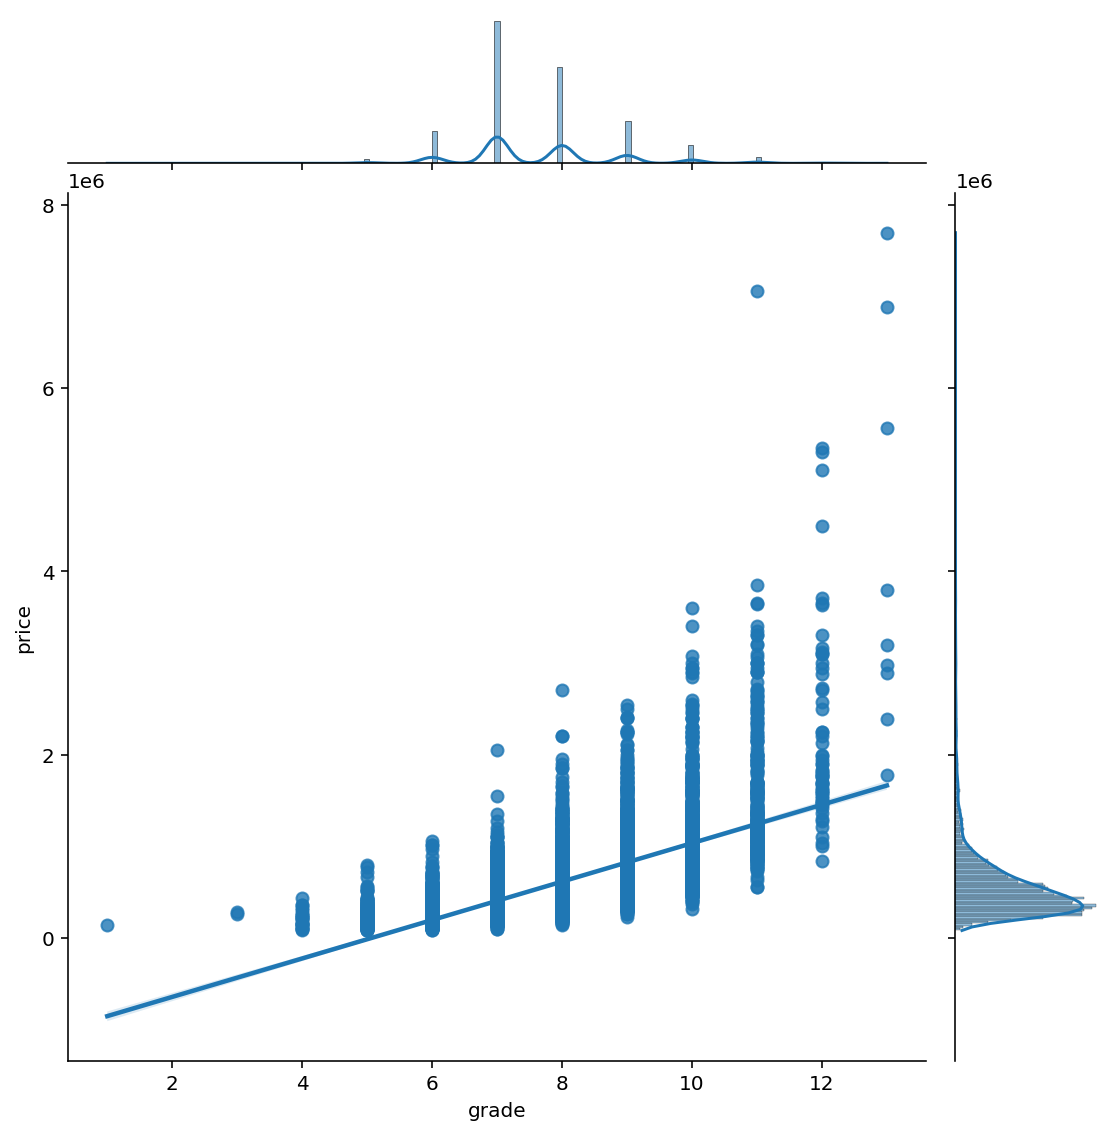

In [10]:
sns.jointplot('grade', 'price', 
              height = 8,
              data = train_data,
              kind = 'reg')

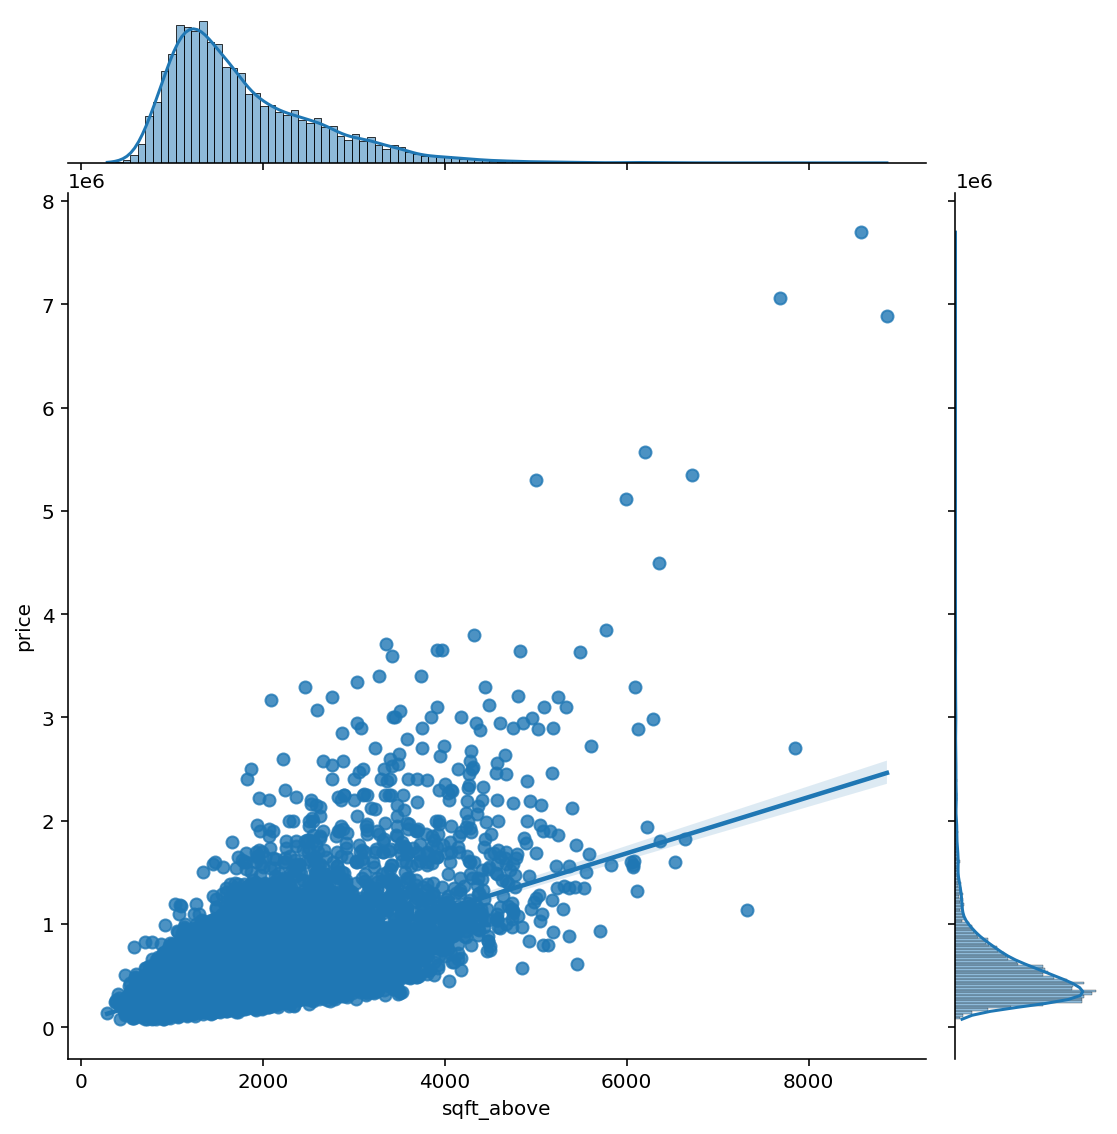

In [11]:
sns.jointplot('sqft_above', 'price', 
              height = 8,
              data = train_data,
              kind = 'reg')

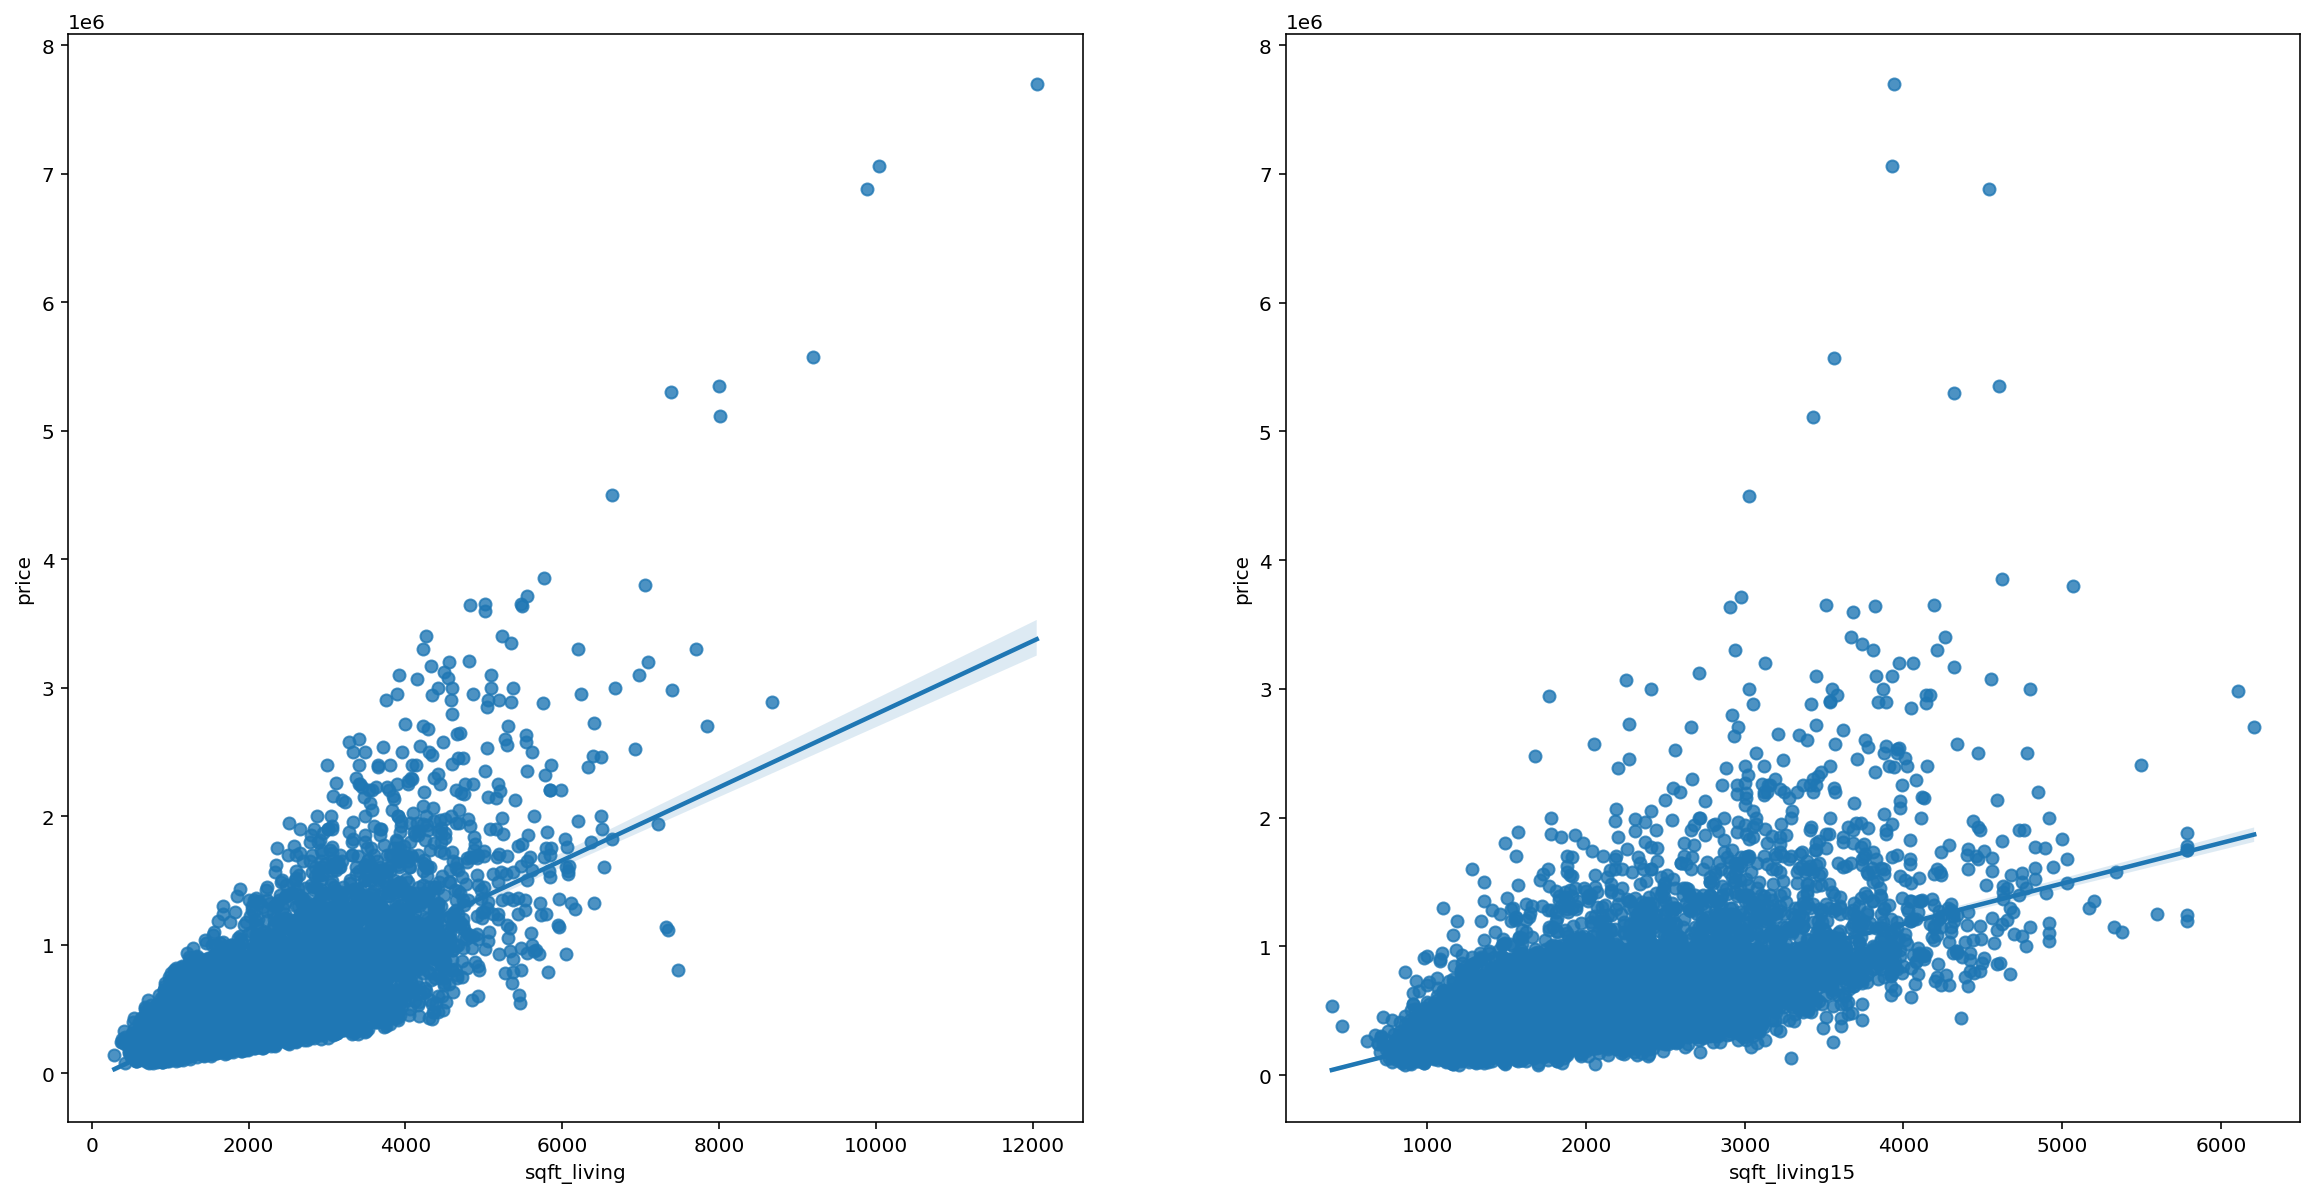

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns. regplot('sqft_living', 'price', data = train_data, ax = ax[0])
sns. regplot('sqft_living15', 'price', data = train_data, ax = ax[1])

In [13]:
bathrooms_count = train_data['bathrooms'].value_counts()
grade_count = train_data['grade'].value_counts()
veiw_count = train_data['view'].value_counts()

print(bathrooms_count)
print(grade_count)
print(veiw_count)

2.50    3748
1.00    2675
1.75    2112
2.25    1433
2.00    1357
1.50    1009
2.75     843
3.50     510
3.00     493
3.25     410
3.75     108
4.00     100
4.50      64
4.25      57
0.75      45
4.75      16
5.00      14
5.25      11
5.50       7
1.25       5
0.00       4
5.75       3
0.50       3
6.00       2
6.25       1
6.75       1
7.75       1
7.50       1
8.00       1
Name: bathrooms, dtype: int64
7     6228
8     4207
9     1855
6     1406
10     781
11     288
5      174
12      60
4       23
13       9
3        2
1        1
Name: grade, dtype: int64
0    13548
2      665
3      373
1      241
4      207
Name: view, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text major ticklabel objects>)

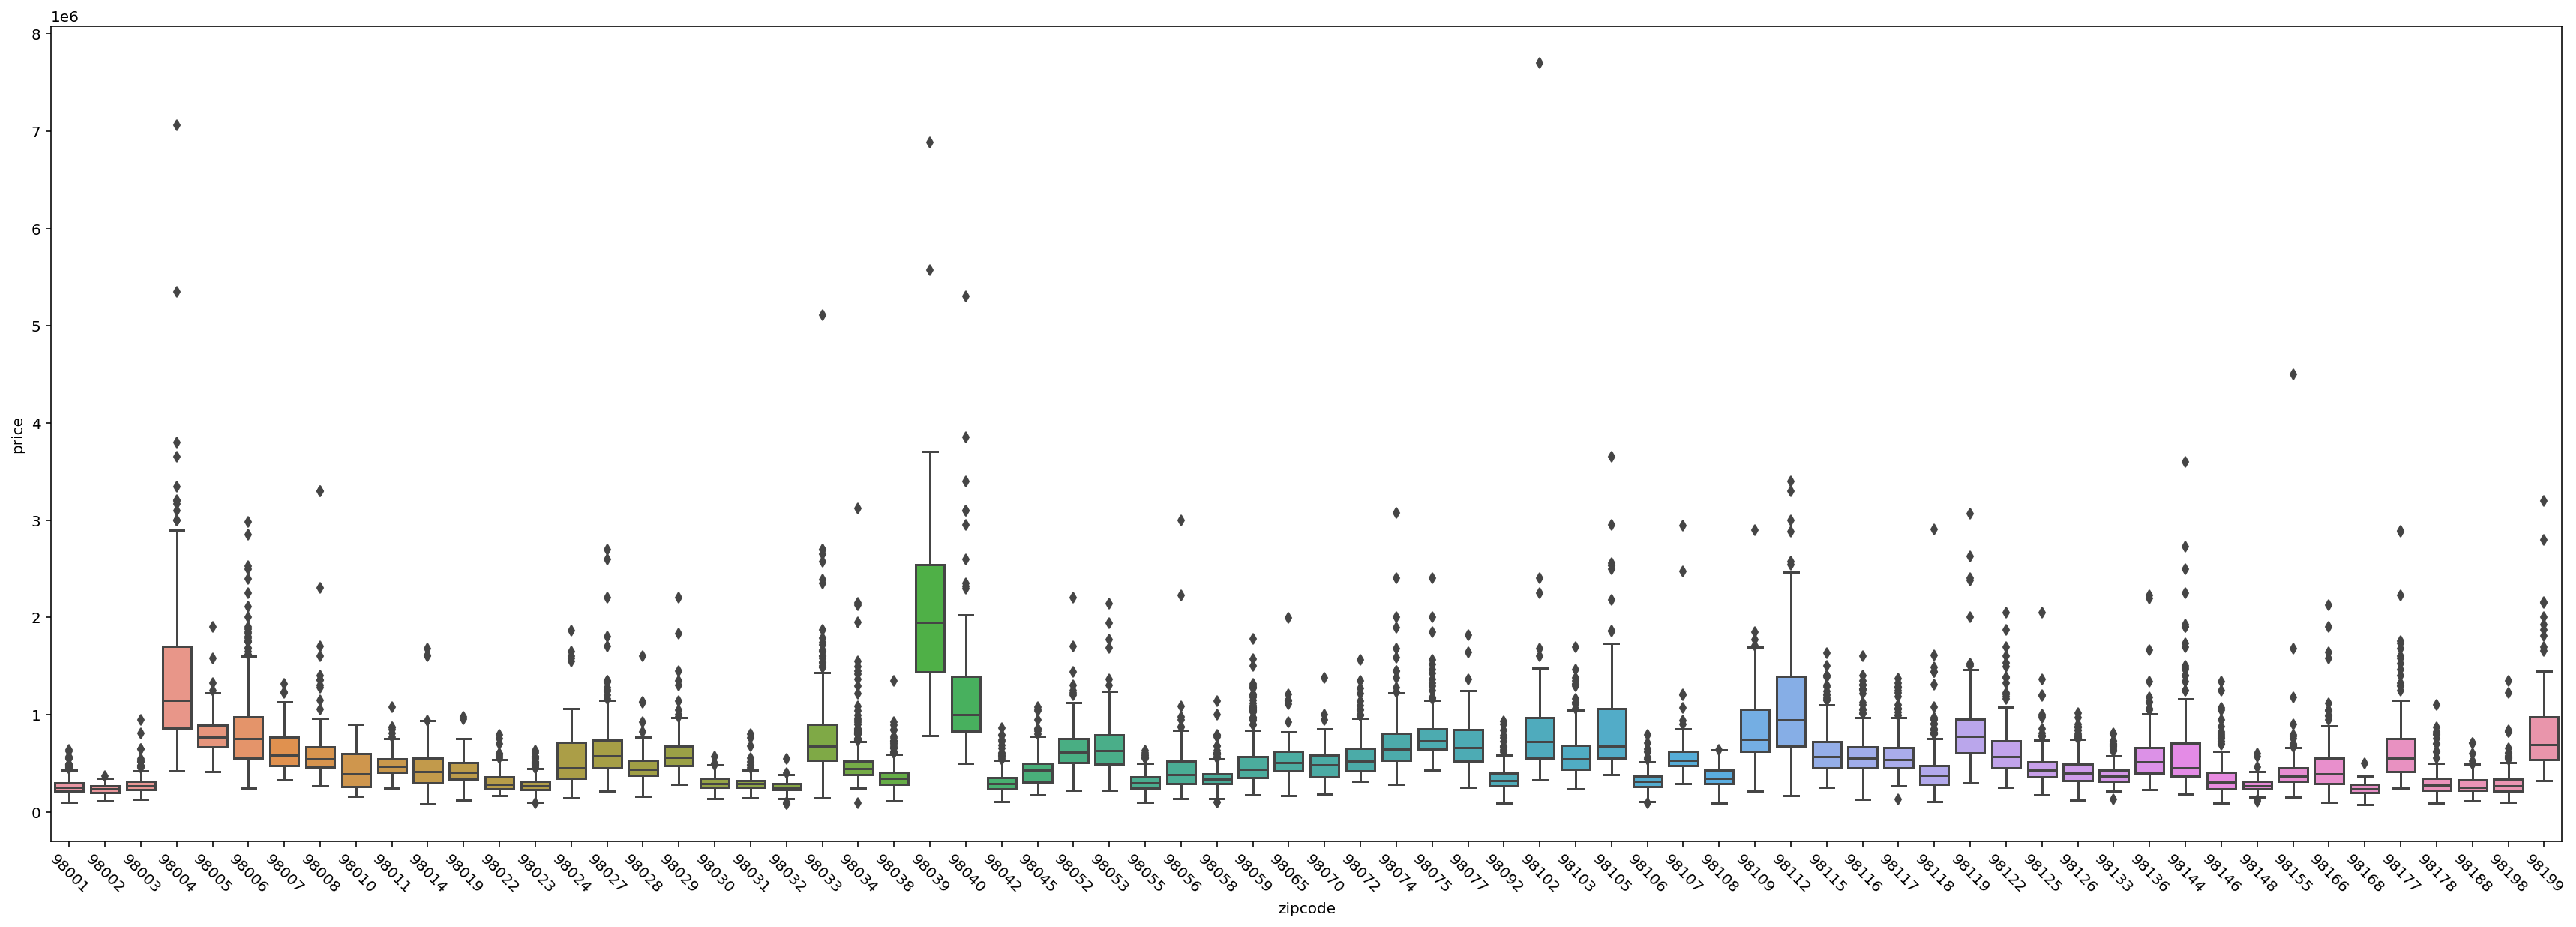

In [14]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.boxplot('zipcode', 'price', data = train_data)
plt.xticks(rotation=-45)

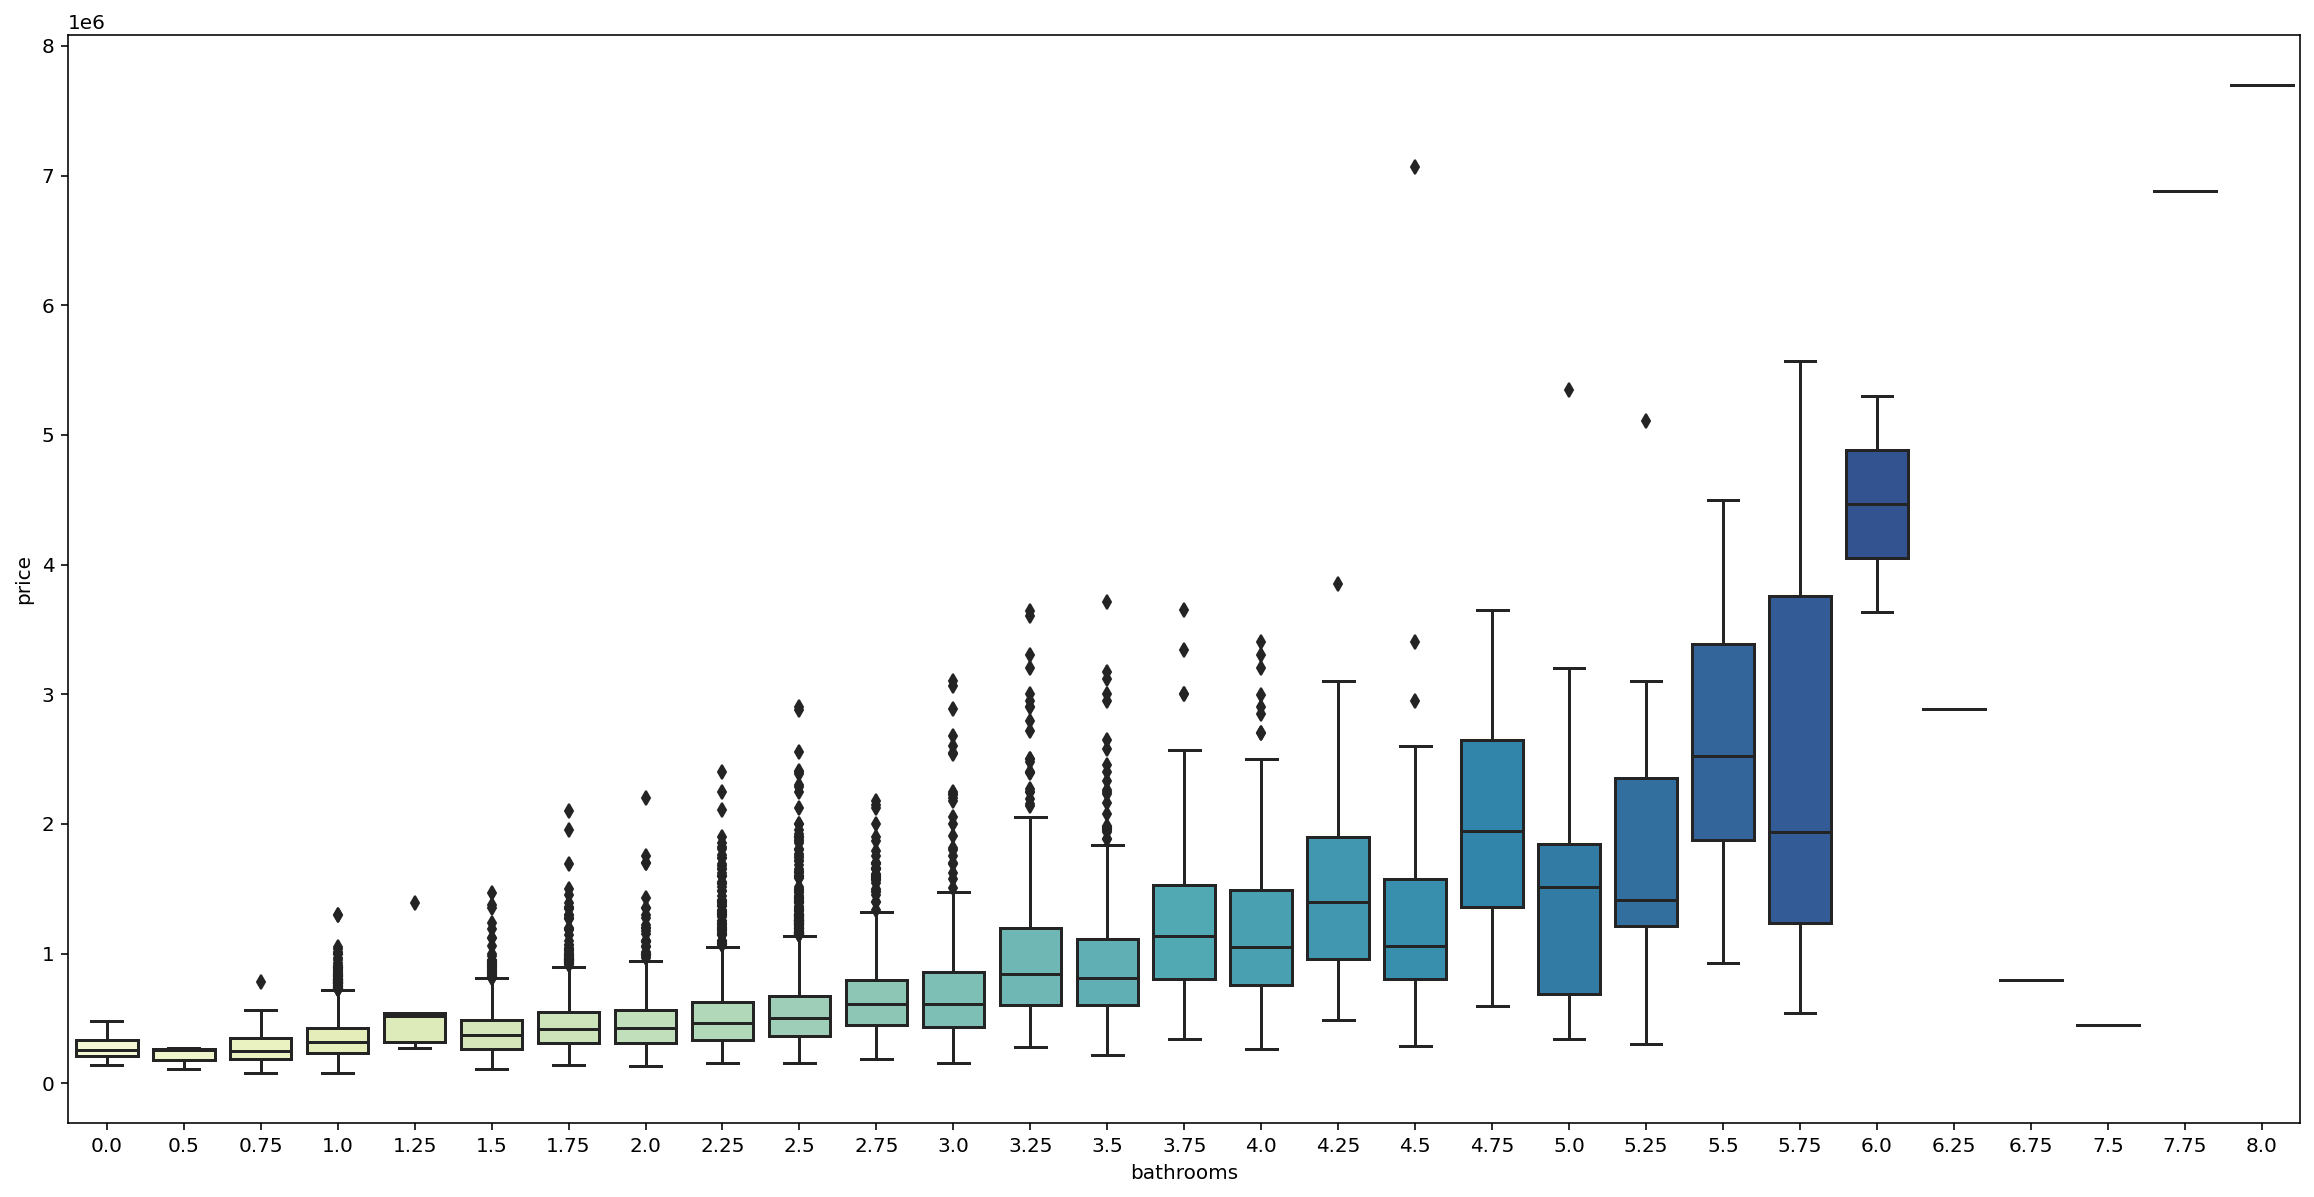

In [15]:
plt.figure(figsize = (20,10))
sns.boxplot('bathrooms', 'price', data = train_data, palette='YlGnBu')

In [16]:
train_data.loc[(train_data['bathrooms'] == 6.25)]
train_data = train_data.loc[train_data['bathrooms'] != 6.25]
train_data.loc[(train_data['bathrooms'] == 6.75)]
train_data = train_data.loc[train_data['bathrooms'] != 6.75]
train_data.loc[(train_data['bathrooms'] == 7.5)]
train_data = train_data.loc[train_data['bathrooms'] != 7.5]
train_data.loc[(train_data['bathrooms'] == 7.75)]
train_data = train_data.loc[train_data['bathrooms'] != 7.75]
train_data.loc[(train_data['bathrooms'] == 4.5) & (train_data['price'] > 7000000)]
train_data = train_data.loc[train_data['id'] != 2775]
train_data.loc[(train_data['bathrooms'] == 5.0) & (train_data['price'] > 5000000)]
train_data = train_data.loc[train_data['id'] != 1045]
train_data.loc[(train_data['bathrooms'] == 5.25) & (train_data['price'] > 5000000)]
train_data = train_data.loc[train_data['id'] != 842]
train_data.loc[(train_data['bathrooms'] == 1.25) & (train_data['price'] > 1000000)]
train_data = train_data.loc[train_data['id'] != 12969]

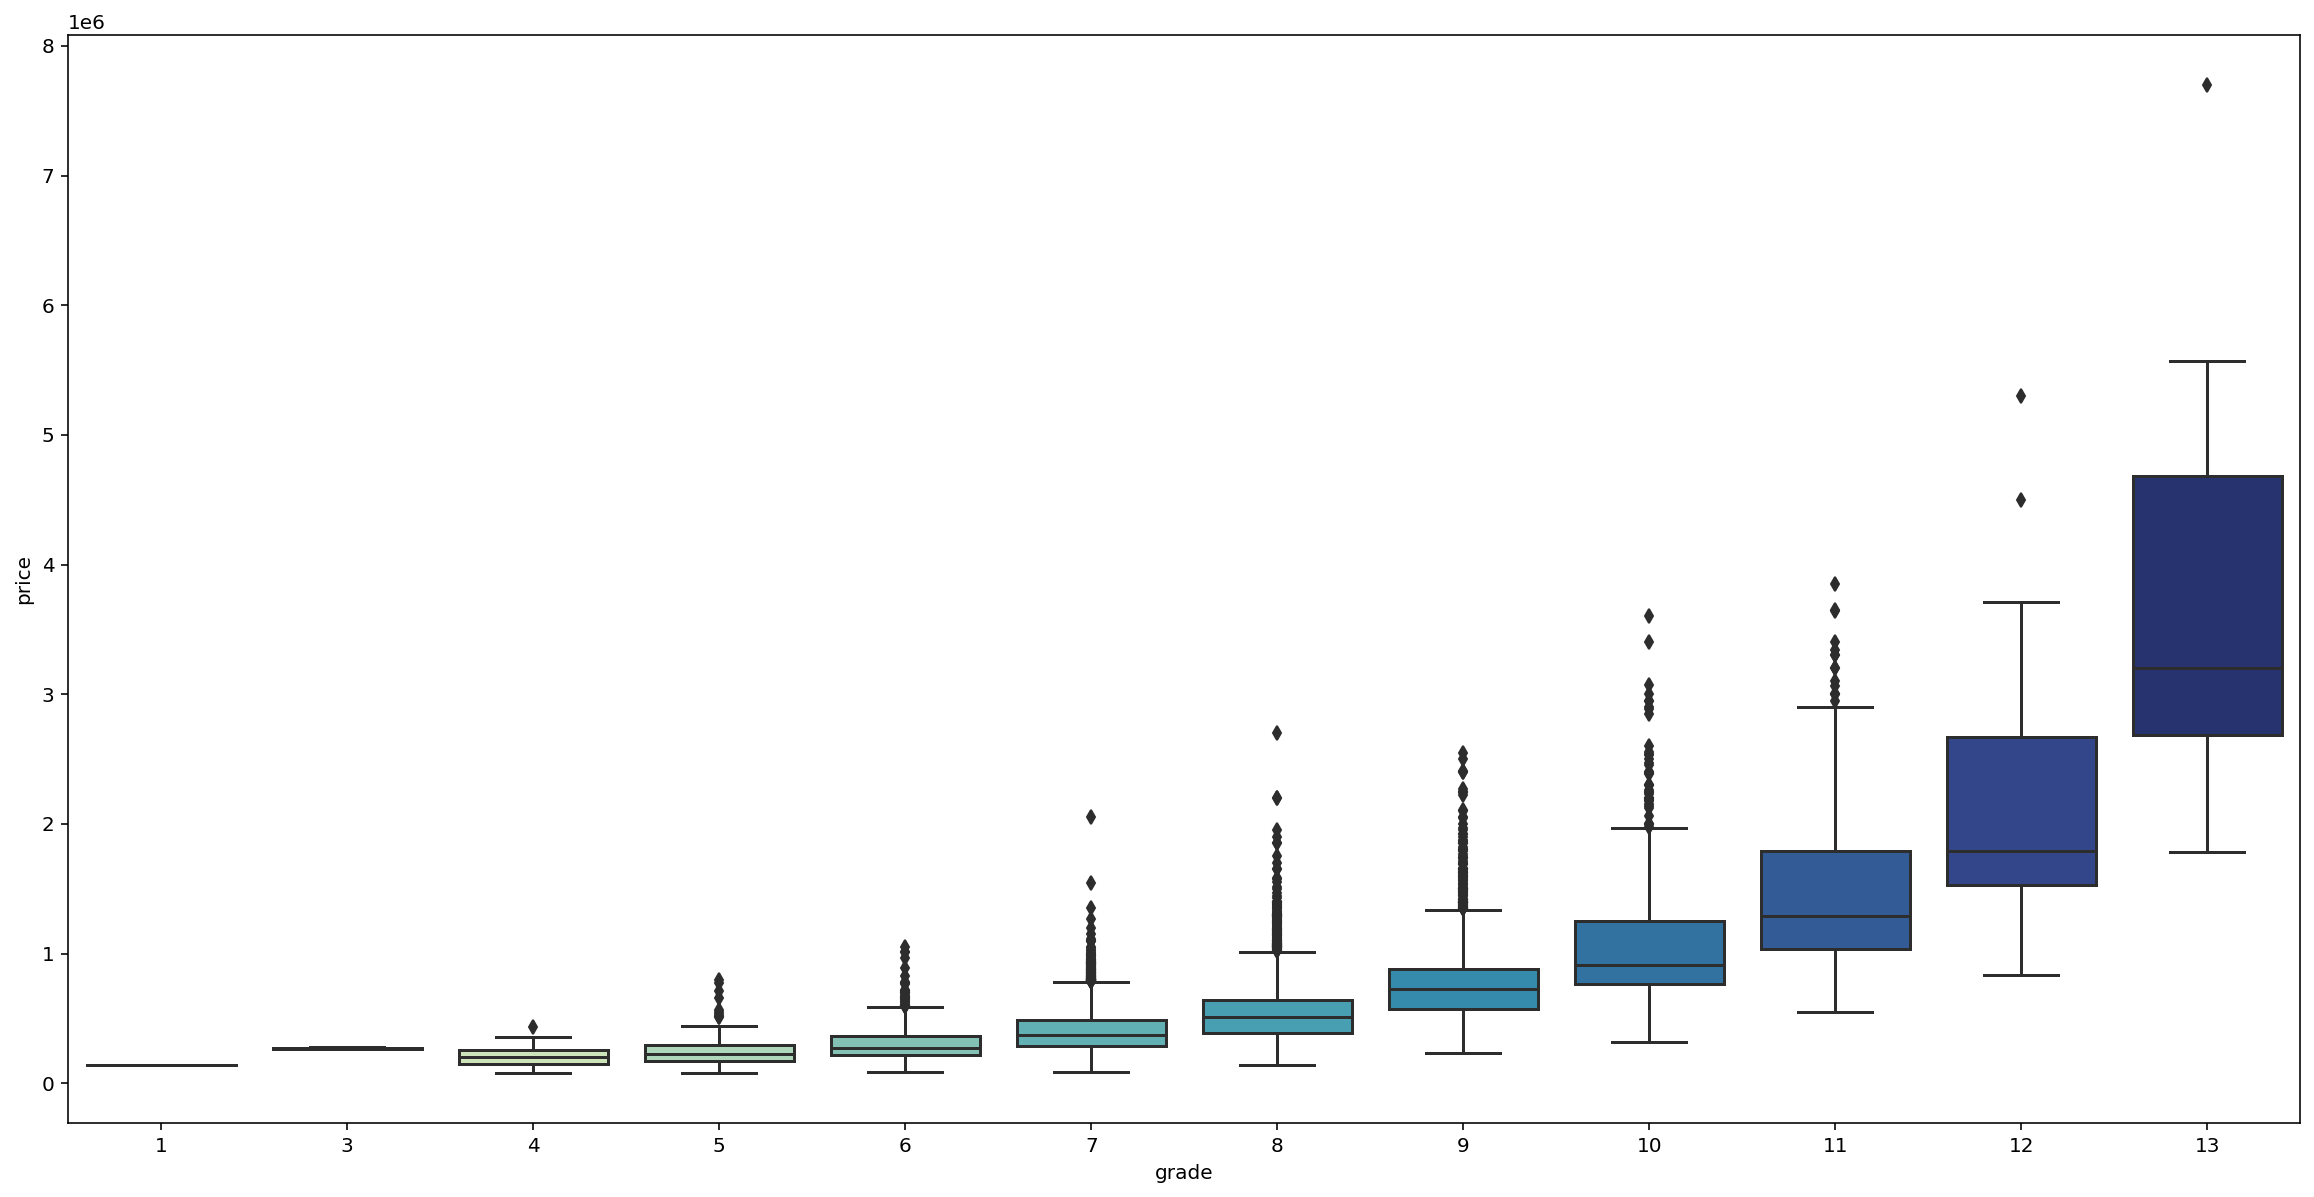

In [17]:
plt.figure(figsize = (20,10))
sns.boxplot('grade', 'price', data = train_data, palette='YlGnBu')

In [18]:
train_data.loc[(train_data['grade'] == 13) & (train_data['price'] > 7000000)]
train_data = train_data.loc[train_data['id'] != 5108]

train_data.loc[(train_data['grade'] == 13) & (train_data['price'] > 5000000)]
train_data = train_data.loc[train_data['id'] != 3134]

train_data.loc[(train_data['grade'] == 12) & (train_data['price'] > 4000000)]
train_data = train_data.loc[train_data['id'] != 947]
train_data = train_data.loc[train_data['id'] != 1882]

train_data.loc[(train_data['grade'] == 11) & (train_data['price'] > 3500000)]
train_data = train_data.loc[train_data['id'] != 1499]

train_data.loc[(train_data['grade'] == 8) & (train_data['price'] > 2500000)]
train_data = train_data.loc[train_data['id'] != 7173]

train_data.loc[(train_data['grade'] == 7) & (train_data['price'] > 2000000)]
train_data = train_data.loc[train_data['id'] != 12346]

train_data.loc[(train_data['grade'] == 10) & (train_data['price'] > 3000000)]
train_data = train_data.loc[train_data['id'] != 2049]
train_data = train_data.loc[train_data['id'] != 5621]

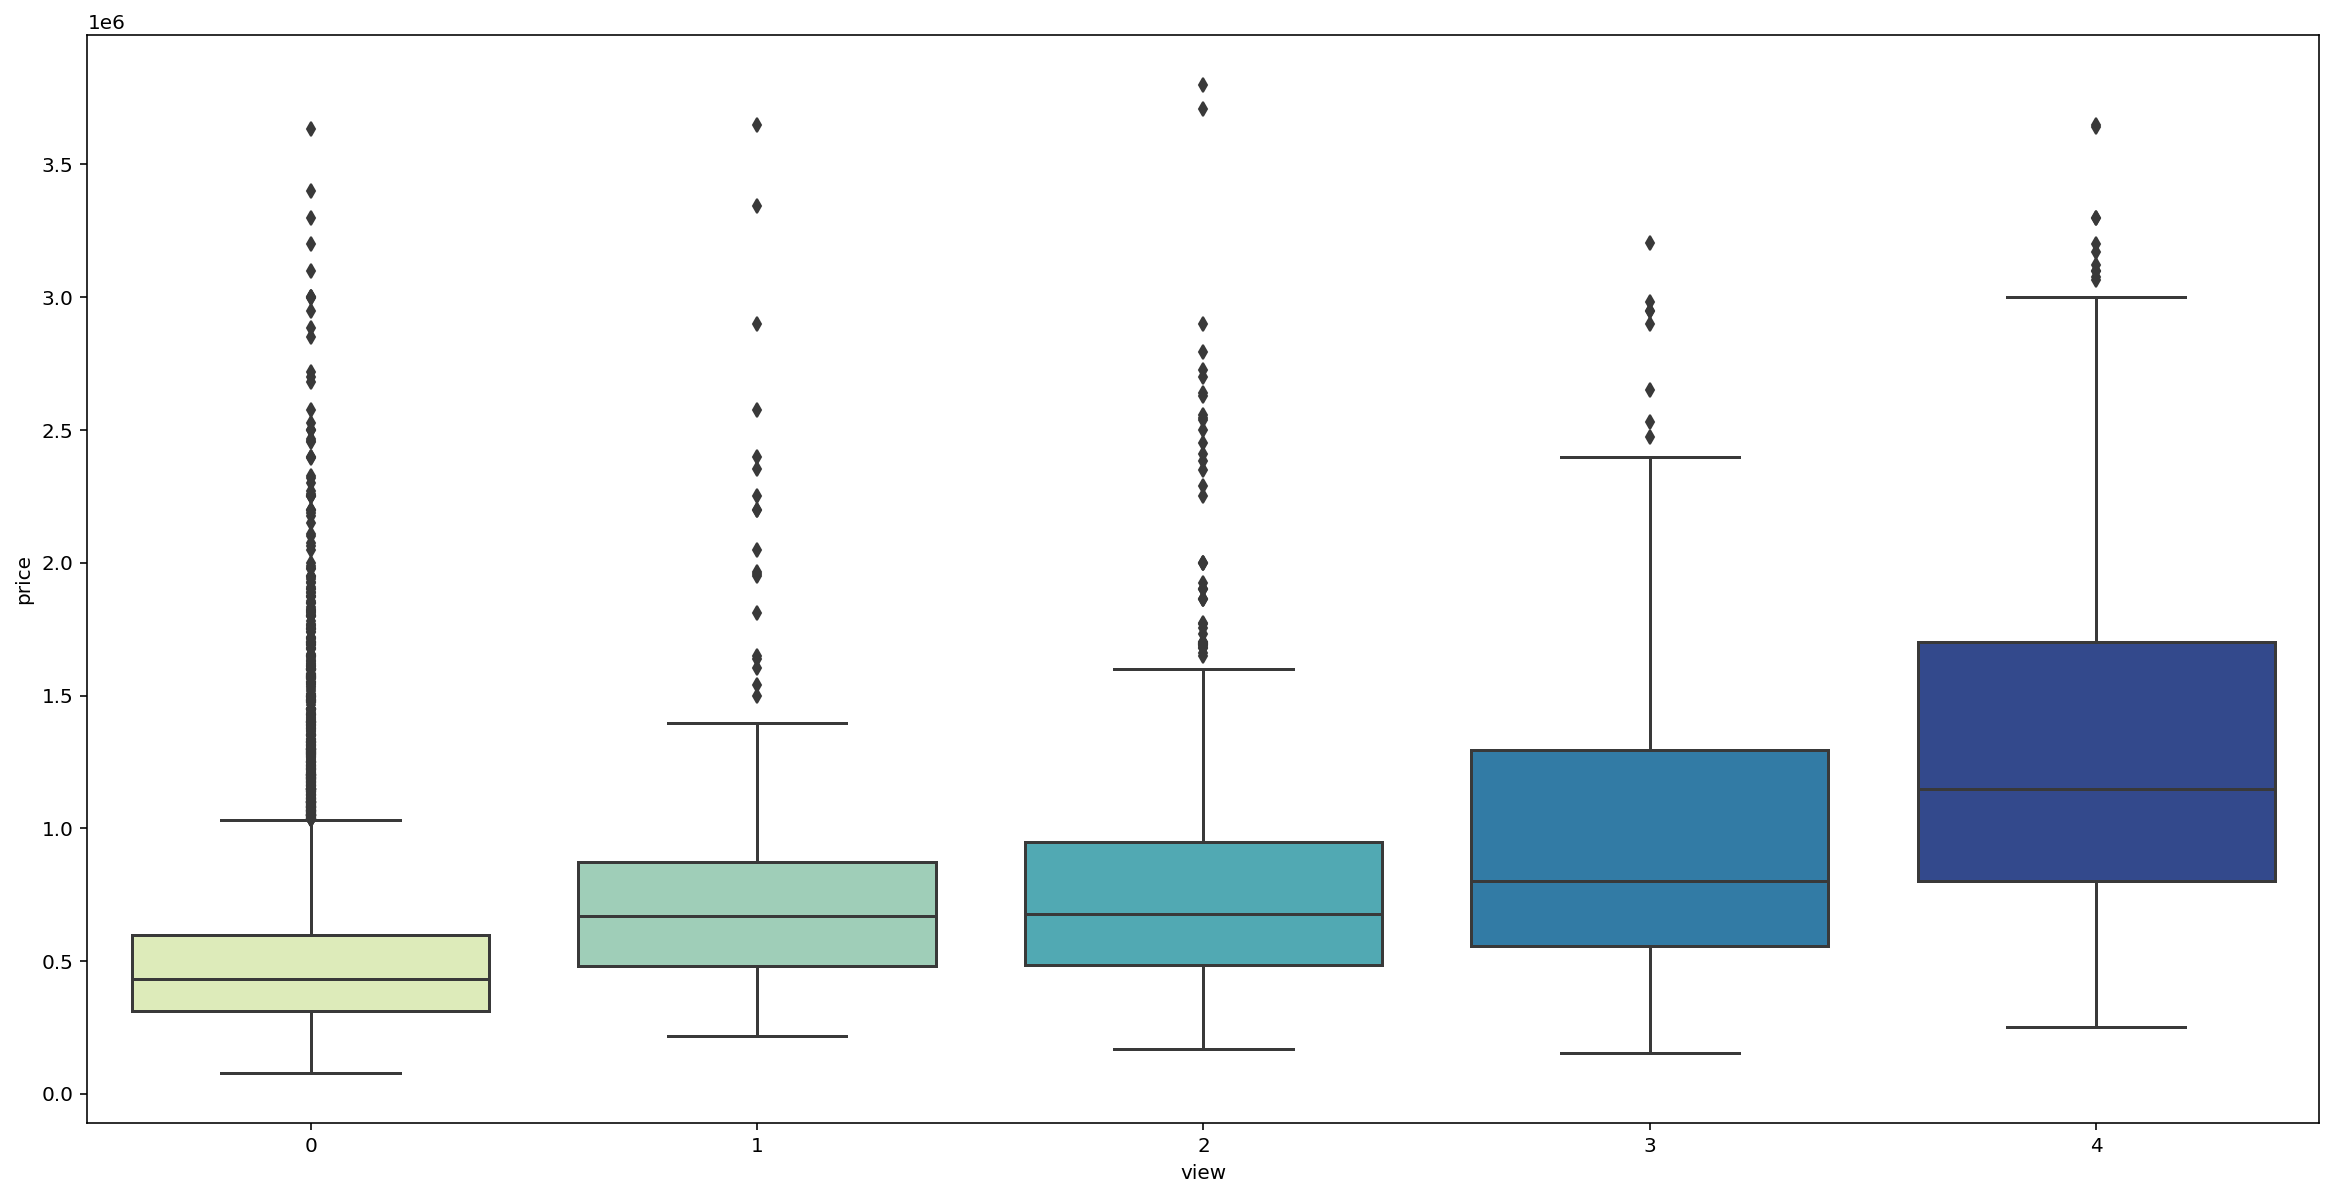

In [19]:
plt.figure(figsize = (20,10))
sns.boxplot('view', 'price', data = train_data, palette='YlGnBu')

In [20]:
train_data.loc[(train_data['view'] == 2) & (train_data['price'] > 3500000)]
train_data = train_data.loc[train_data['id'] != 4957]
train_data = train_data.loc[train_data['id'] != 11364]

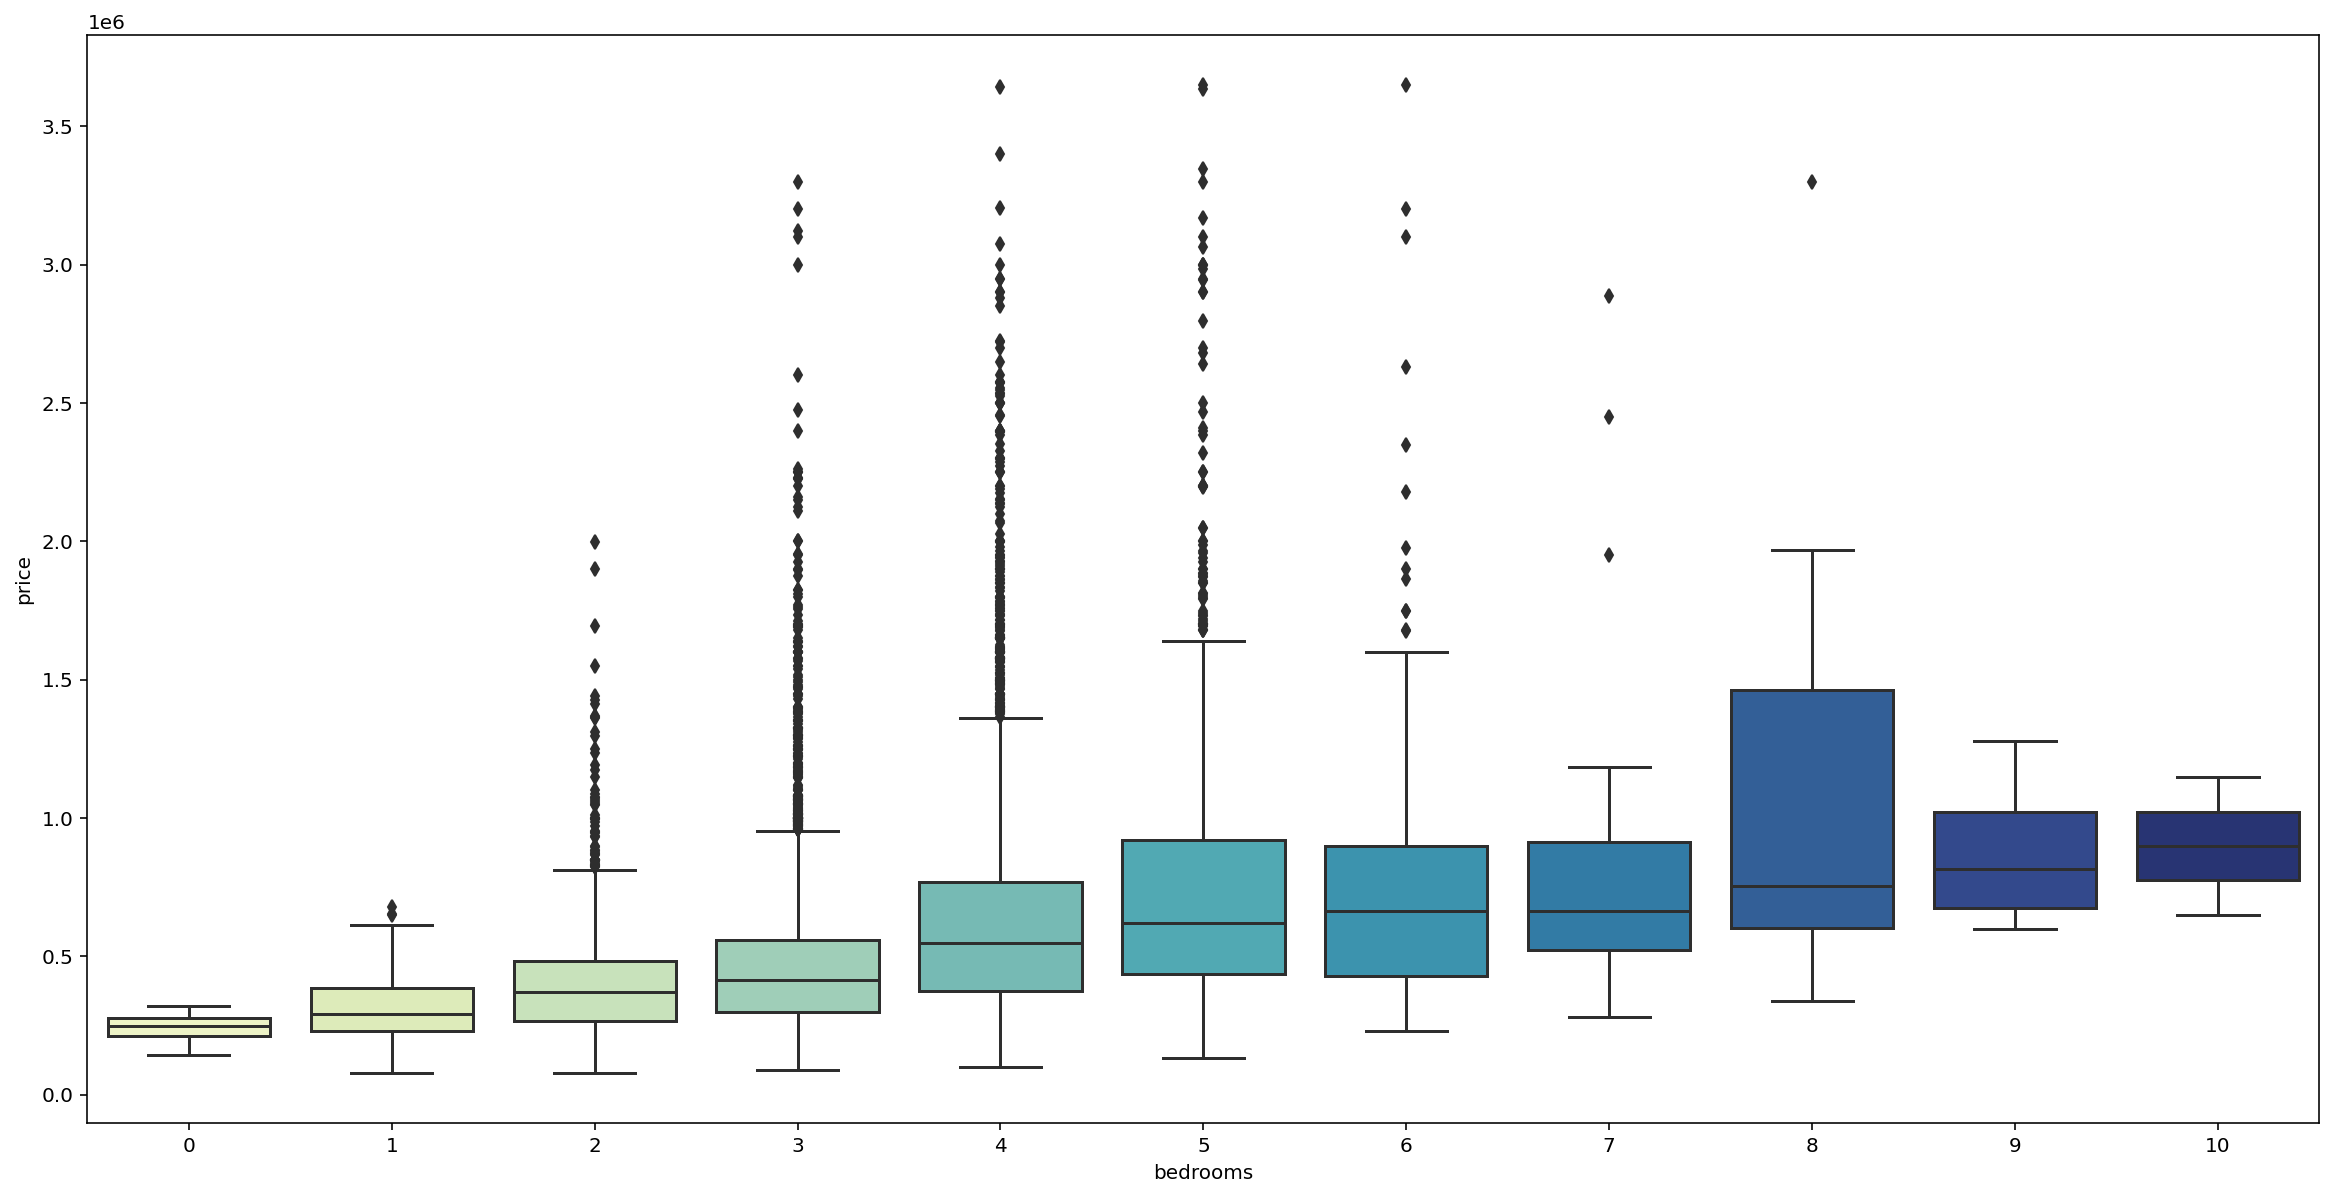

In [21]:
plt.figure(figsize = (20,10))
sns.boxplot('bedrooms', 'price', data = train_data, palette='YlGnBu')

In [22]:
train_data.loc[(train_data['bedrooms'] == 8) & (train_data['price'] > 3000000)]
train_data.loc[(train_data['bedrooms'] == 7) & (train_data['price'] > 1500000)]
train_data = train_data.loc[train_data['id'] != 12845]
train_data = train_data.loc[train_data['id'] != 411]
train_data = train_data.loc[train_data['id'] != 9772]
train_data = train_data.loc[train_data['id'] != 10476]

In [23]:
train_data['date'] = train_data['date'].apply(lambda i : i[:6]).astype(int)
target_price = train_data['price']

train_data

id    date      price  ...     long  sqft_living15  sqft_lot15
0          0  201410   221900.0  ... -122.257           1340        5650
1          1  201502   180000.0  ... -122.233           2720        8062
2          2  201502   510000.0  ... -122.045           1800        7503
3          3  201406   257500.0  ... -122.327           2238        6819
4          4  201501   291850.0  ... -122.315           1650        9711
...      ...     ...        ...  ...      ...            ...         ...
15030  15030  201410   610685.0  ... -122.167           2520        6023
15031  15031  201503  1007500.0  ... -122.398           2050        6200
15032  15032  201405   360000.0  ... -122.346           1530        1509
15033  15033  201502   400000.0  ... -122.362           1830        7200
15034  15034  201410   325000.0  ... -122.299           1020        1357

[15011 rows x 21 columns]

In [24]:
sub_data['date'] = sub_data['date'].apply(lambda i : i[:6]).astype(int)

sub_data

id    date  bedrooms  ...     long  sqft_living15  sqft_lot15
0     15035  201412         3  ... -122.319           1690        7639
1     15036  201412         4  ... -122.393           1360        5000
2     15037  201405         4  ... -122.005           4760      101930
3     15038  201504         3  ... -122.337           1780        8113
4     15039  201503         3  ... -122.031           2390        7570
...     ...     ...       ...  ...      ...            ...         ...
6463  21498  201406         3  ... -122.002           1320       11303
6464  21499  201501         3  ... -122.288           1400        1230
6465  21500  201502         3  ... -122.409           1330        1265
6466  21501  201406         2  ... -122.299           1020        2007
6467  21502  201501         3  ... -122.069           1410        1287

[6468 rows x 20 columns]

In [25]:
train_data['zipcode'] = train_data.zipcode.astype('string')
print(len(train_data['zipcode'].unique()))
train_data['zipcode'].unique()

70


<StringArray>
['98178', '98028', '98074', '98003', '98198', '98007', '98115', '98107',
 '98126', '98019', '98103', '98002', '98133', '98040', '98030', '98119',
 '98112', '98027', '98117', '98058', '98001', '98056', '98166', '98053',
 '98023', '98105', '98042', '98008', '98148', '98122', '98004', '98005',
 '98034', '98125', '98075', '98010', '98038', '98059', '98092', '98136',
 '98199', '98032', '98045', '98102', '98077', '98108', '98168', '98177',
 '98118', '98006', '98146', '98033', '98052', '98155', '98024', '98116',
 '98144', '98011', '98031', '98106', '98065', '98022', '98070', '98014',
 '98055', '98072', '98029', '98188', '98109', '98039']
Length: 70, dtype: string

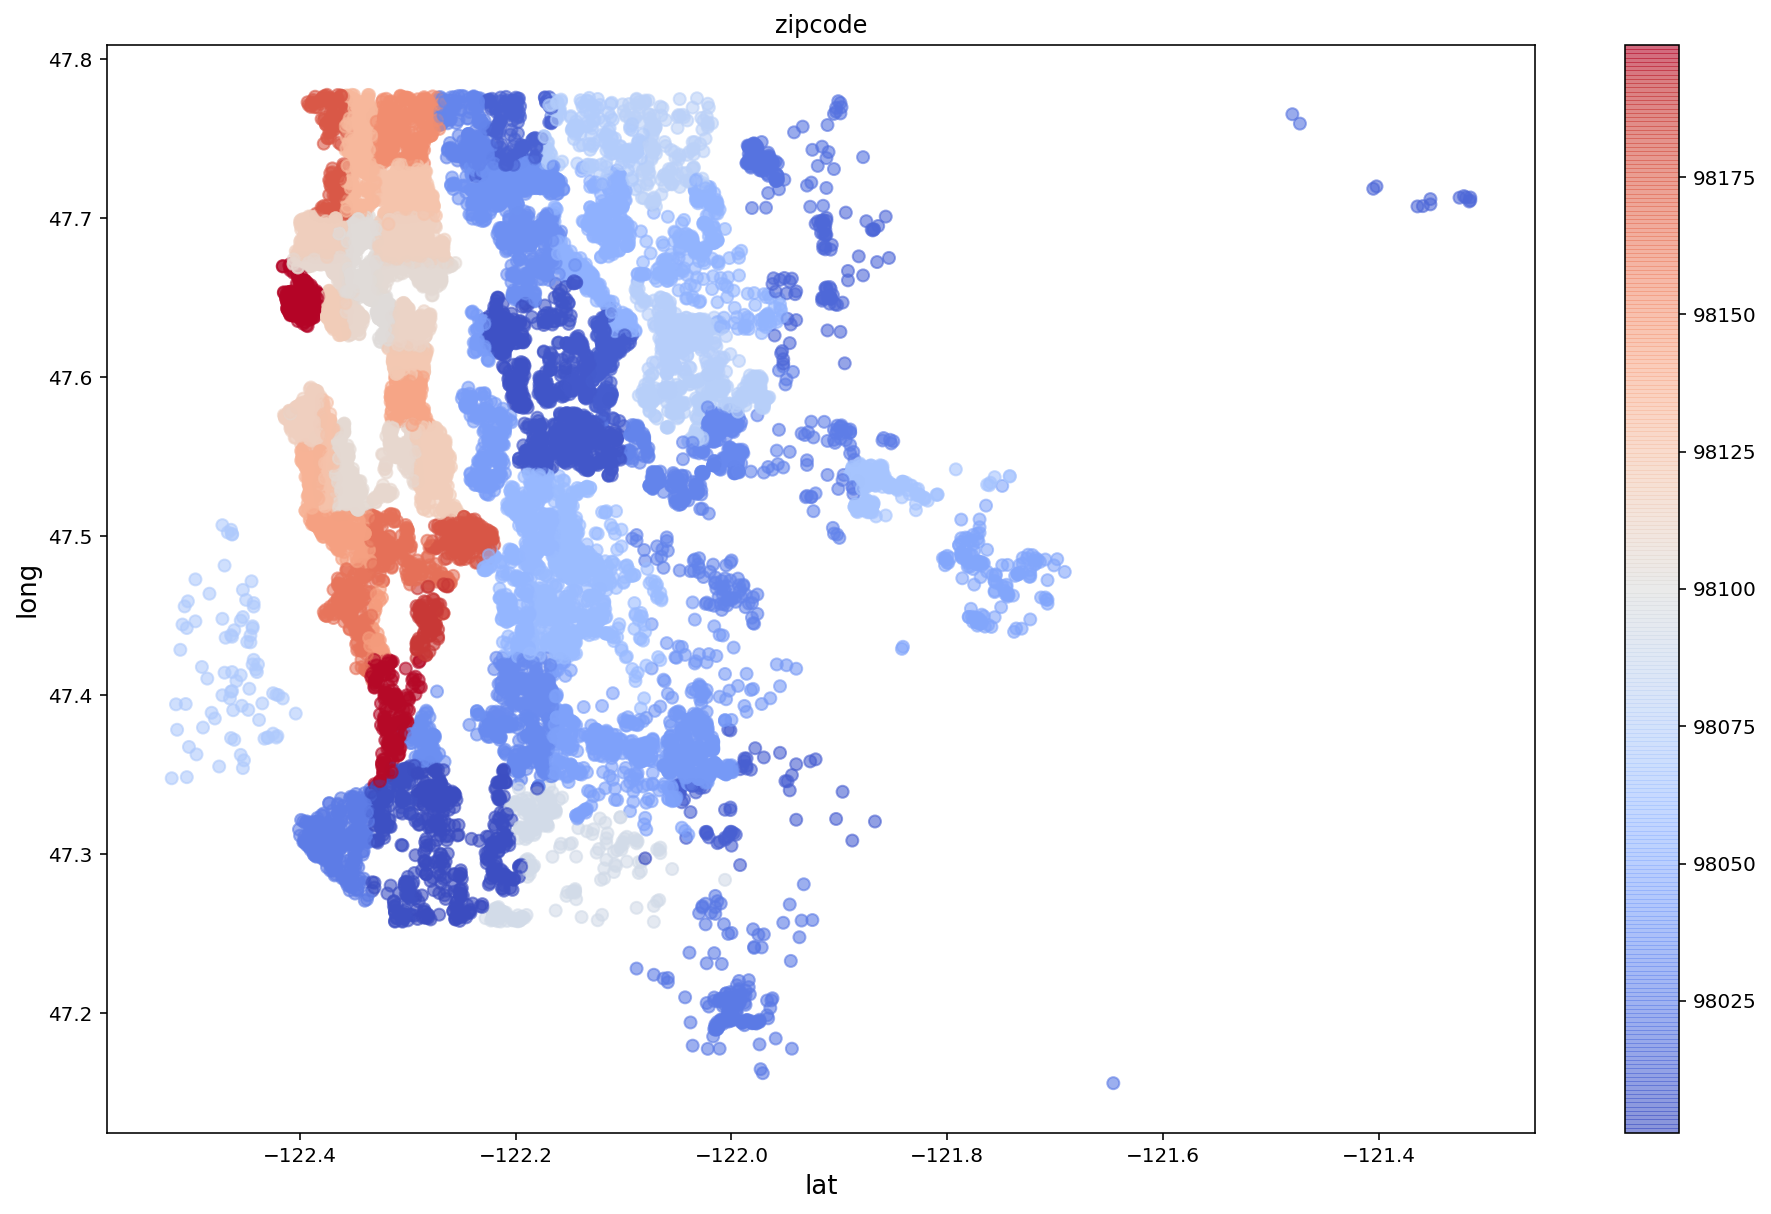

In [26]:
train_data['zipcode'] = train_data.zipcode.astype('int')
fig, ax = plt.subplots(figsize=(16, 10))

plt.scatter(train_data["long"], train_data["lat"], c=train_data["zipcode"], cmap='coolwarm', alpha=.6)
plt.xlabel("lat", fontsize=13)
plt.ylabel("long", fontsize=13)
plt.title('zipcode')
plt.colorbar()
plt.show()

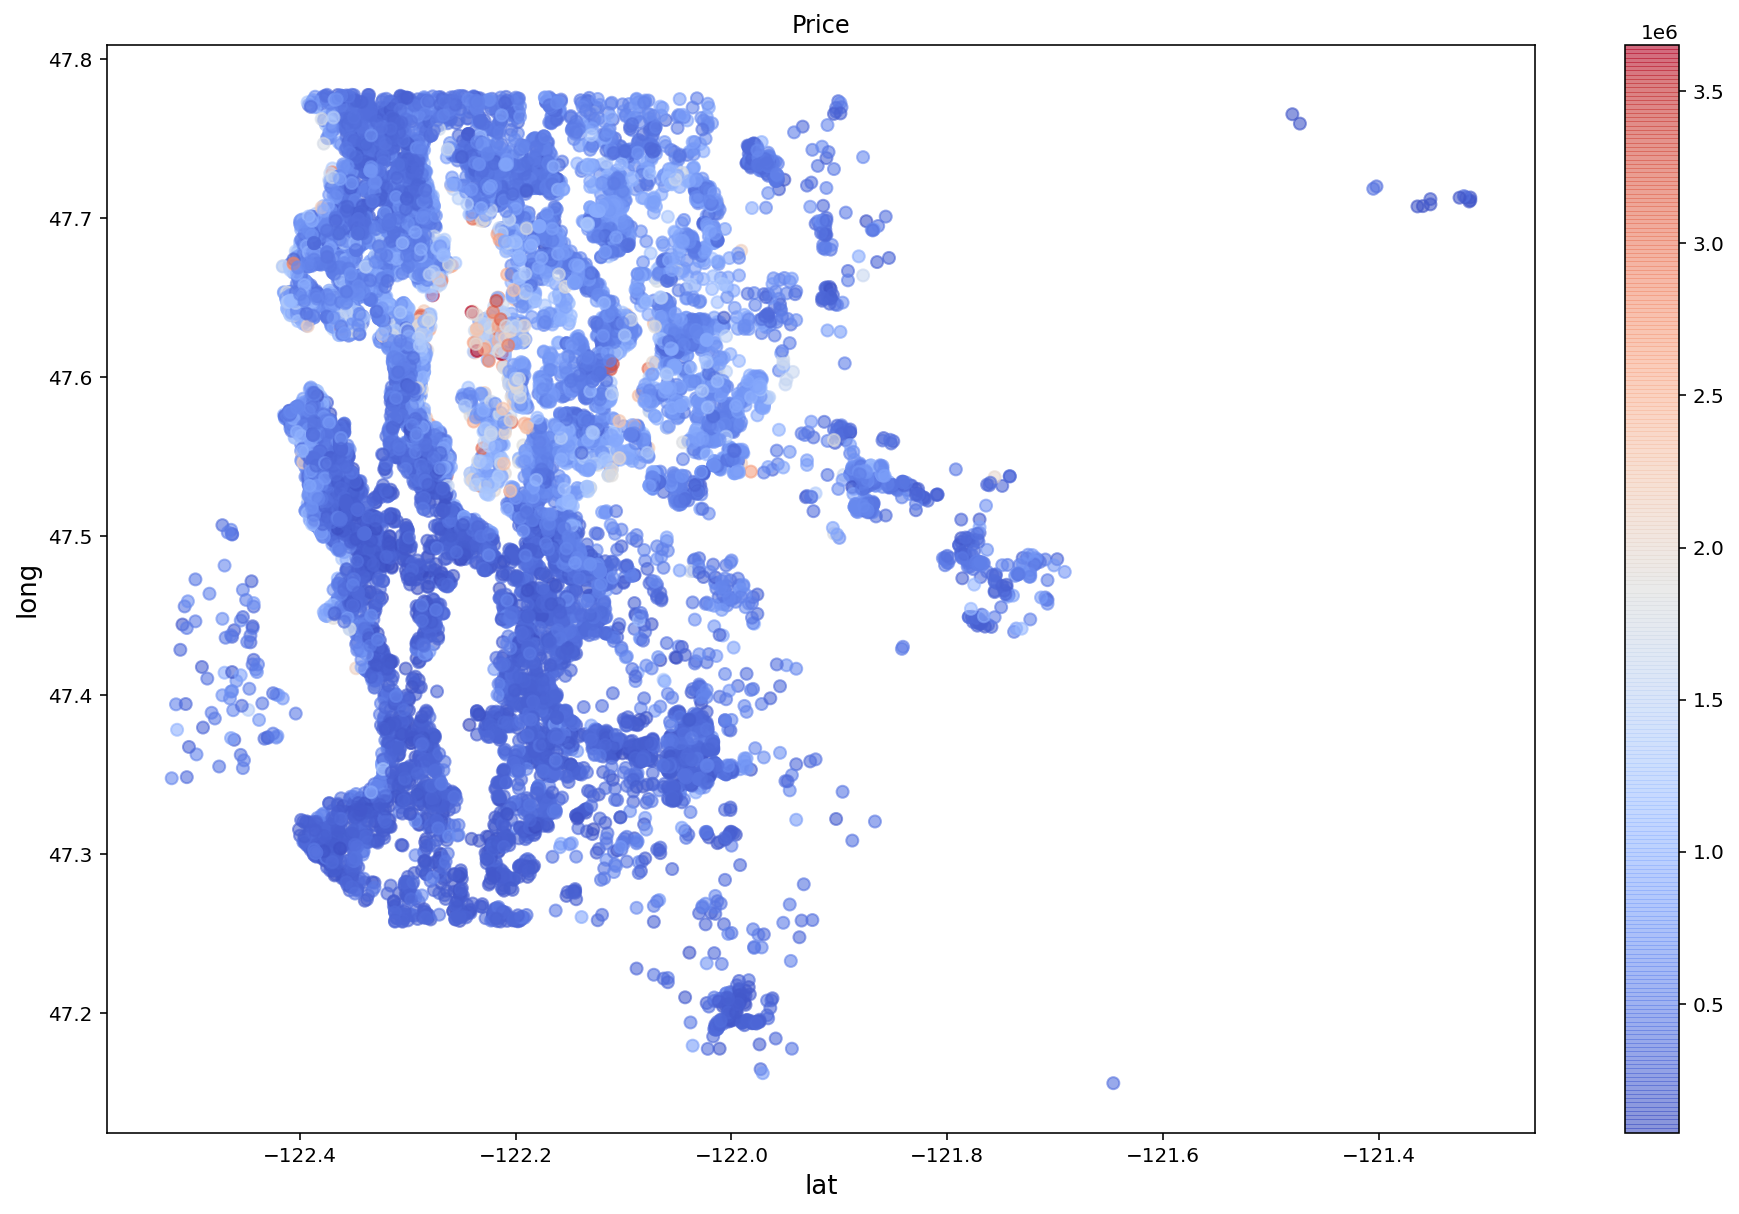

In [27]:
fig, ax = plt.subplots(figsize=(16, 10))

plt.scatter(train_data["long"], train_data["lat"], c=train_data["price"], cmap='coolwarm', alpha=.6)
plt.xlabel("lat", fontsize=13)
plt.ylabel("long", fontsize=13)
plt.title('Price')
plt.colorbar()
plt.show()

In [ ]:
import folium, json
from folium import plugins

state_geo = '/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson'
state_geo_load = json.load(open(state_geo, encoding='utf-8'))
m = folium.Map(location=[47.5112, -122.257], tiles='cartodbpositron', zoom_start=11)
m.choropleth(
    geo_data = state_geo_load,
    name='price',
    data=train_data,
    columns=('price', 'view'),
    key_on='feature.properties.merged',
    fill_color='PuRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='peopple count index'
)

plugins.Fullscreen(position = 'topright',
                   title='Click to Expand',
                   title_cancel='Click to Exit',
                   force_separate_button=True).add_to(m)

for i in train_data.index:
  folium.Circle([train_data['lat'][i], train_data['long'][i]],
                      radius=3, color = '#cc316a').add_to(m)

plugins.MousePosition().add_to(m)
m.save('/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/lat_long.html')
m

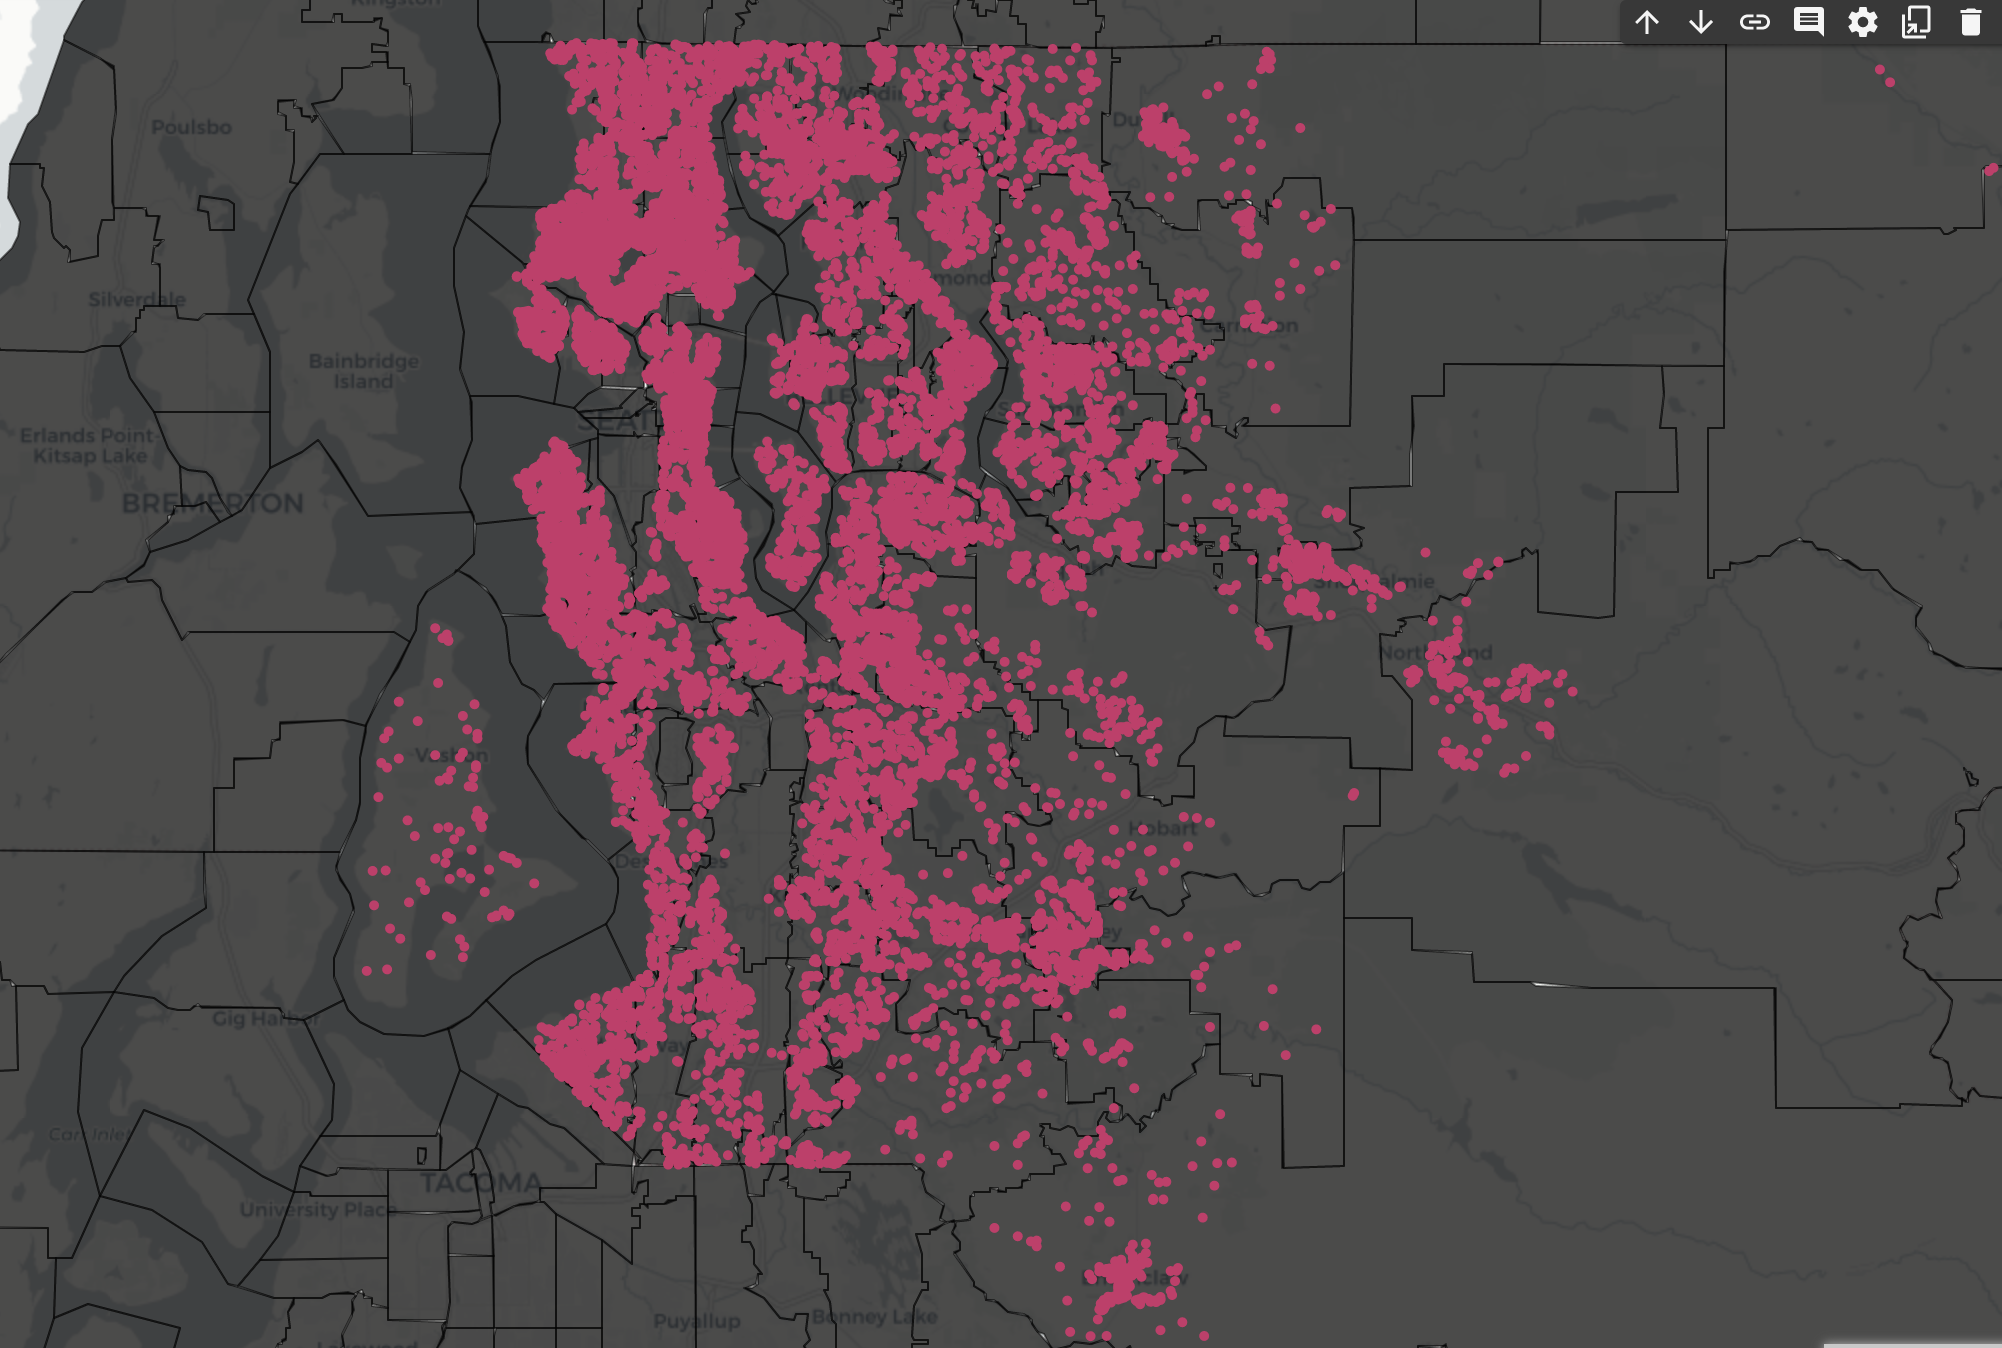

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15011 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15011 non-null  int64  
 1   date           15011 non-null  int64  
 2   price          15011 non-null  float64
 3   bedrooms       15011 non-null  int64  
 4   bathrooms      15011 non-null  float64
 5   sqft_living    15011 non-null  int64  
 6   sqft_lot       15011 non-null  int64  
 7   floors         15011 non-null  float64
 8   waterfront     15011 non-null  int64  
 9   view           15011 non-null  int64  
 10  condition      15011 non-null  int64  
 11  grade          15011 non-null  int64  
 12  sqft_above     15011 non-null  int64  
 13  sqft_basement  15011 non-null  int64  
 14  yr_built       15011 non-null  int64  
 15  yr_renovated   15011 non-null  int64  
 16  zipcode        15011 non-null  int64  
 17  lat            15011 non-null  float64
 18  long  

In [ ]:
from scipy.stats import gaussian_kde
x = train_data["long"]
y = train_data["lat"]
z = train_data['zipcode']

plt.figure(figsize=(8,5))
plt.scatter(x, y, c=z, s=50, cmap=plt.cm.jet, edgecolor='')

hist, xbins, ybins, im  = plt.hist2d(train_data["long"],  train_data["lat"], (4, 4), alpha=.8, cmap=plt.cm.jet)
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.text(xbins[j]+10,ybins[i]+55, str(int(hist.T[i,j])), fontsize=13,
                color="w", ha="center", va="center", fontweight="bold")
plt.title('zipcode 산점도')
plt.xlabel('Lat')
plt.ylabel('Long')      
plt.colorbar()
plt.show()

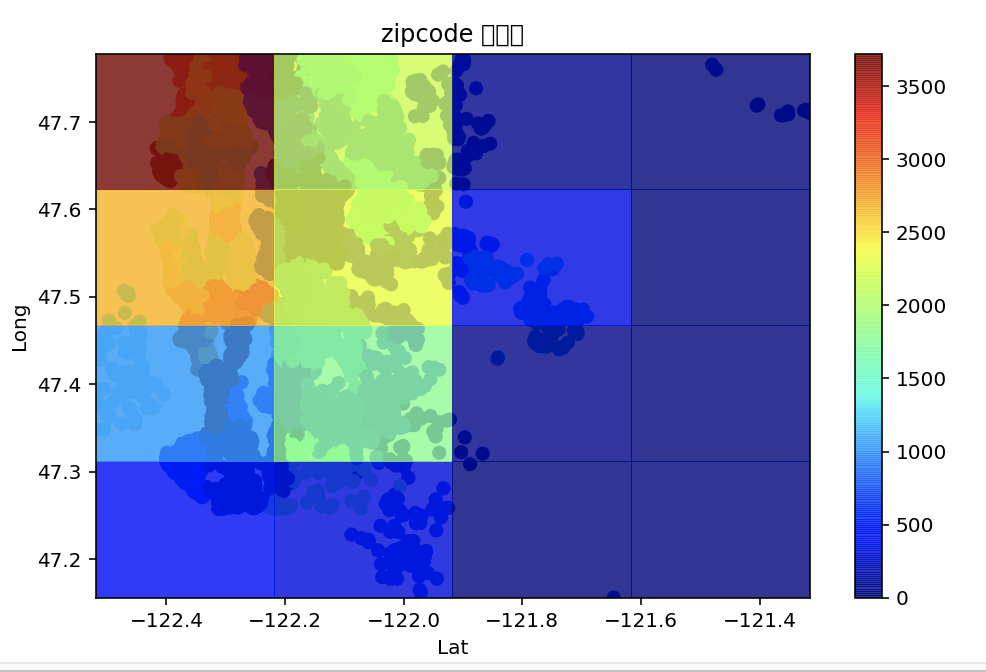

In [ ]:
from scipy.stats import gaussian_kde
x = train_data["long"]
y = train_data["lat"]
z = train_data['price']

plt.figure(figsize=(8,5))
plt.scatter(x, y, c=z, s=50, cmap=plt.cm.jet, edgecolor='')

hist, xbins, ybins, im  = plt.hist2d(train_data["long"],  train_data["lat"], (4, 4), alpha=.8, cmap=plt.cm.jet)
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.text(xbins[j]+10,ybins[i]+55, str(int(hist.T[i,j])), fontsize=13,
                color="w", ha="center", va="center", fontweight="bold")
plt.title('Price')
plt.xlabel('Lat')
plt.ylabel('Long')      
plt.colorbar()
plt.show()

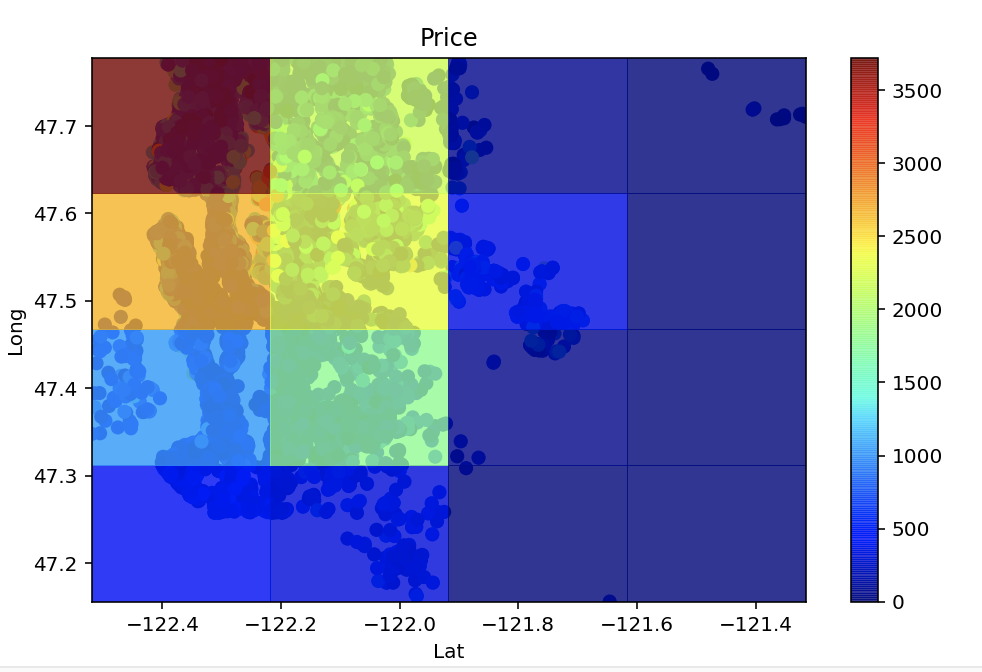

In [32]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

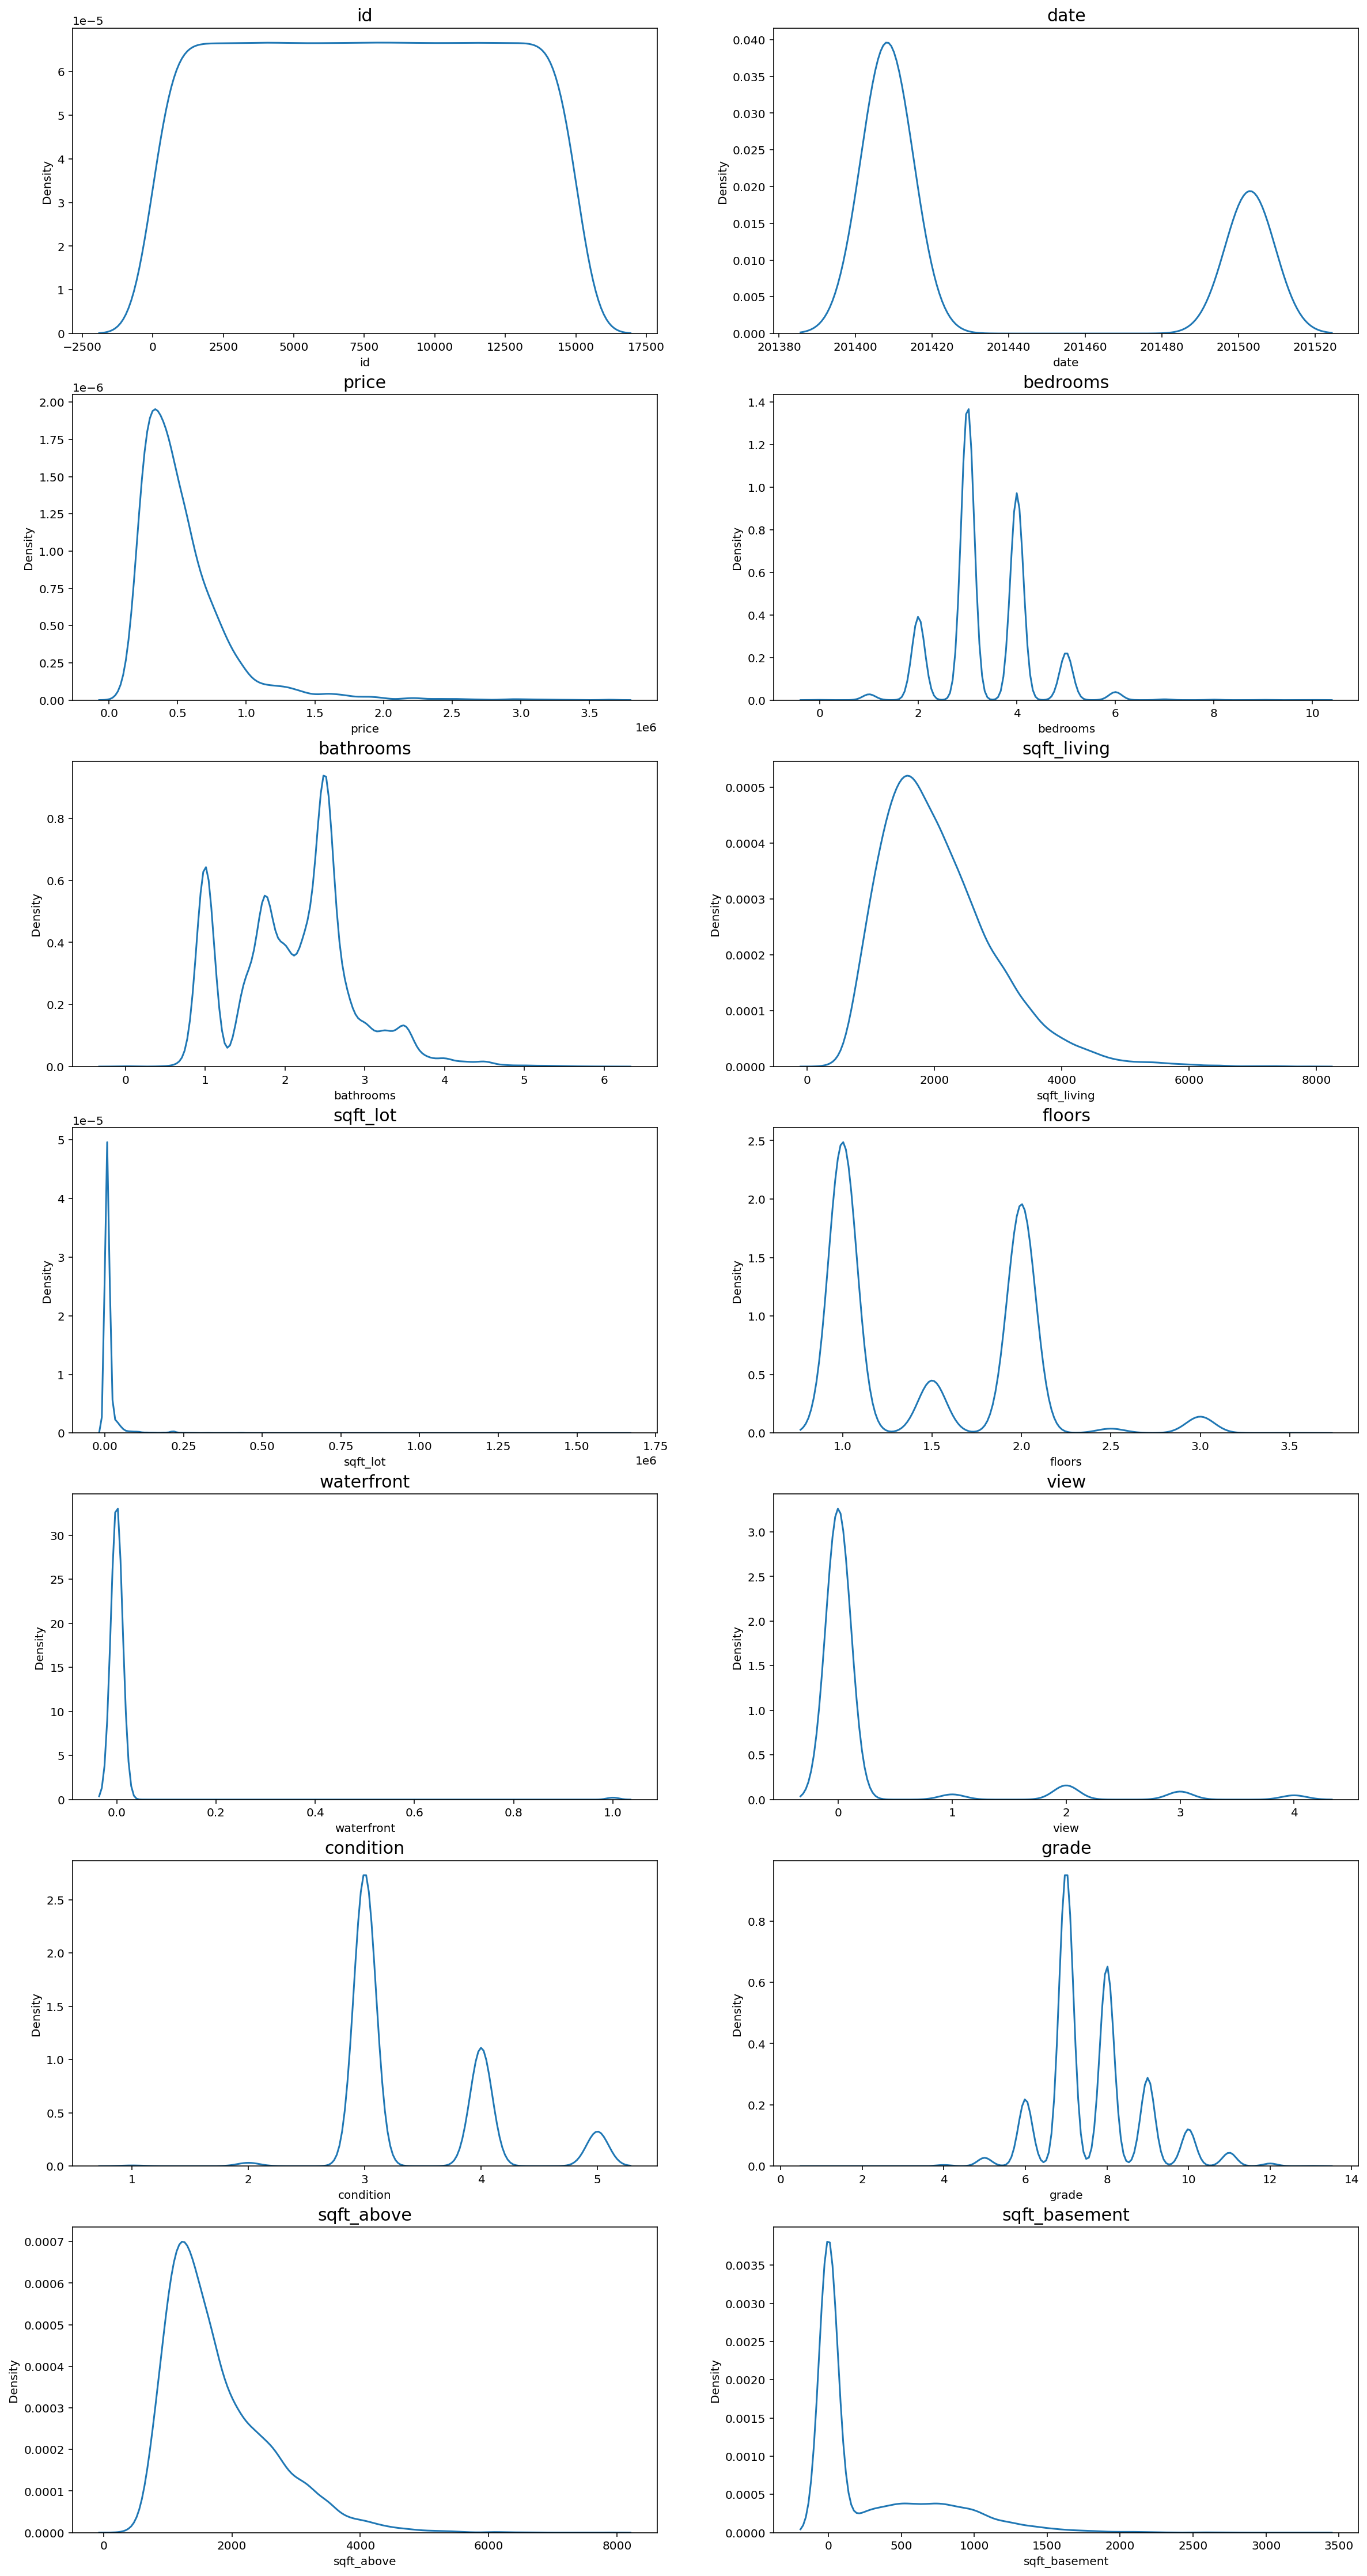

In [33]:
fig, ax = plt.subplots(7, 2, figsize=(20, 40))

count = 0
columns = train_data.columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 15 :
            break

In [34]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [35]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

In [37]:
skew_columns = ['date', 'bedrooms', 'bathrooms',  'sqft_lot', 'floors',
        'condition', 'grade', 
       'sqft_basement', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train_data[c] = np.log1p(train_data[c].values)

In [38]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

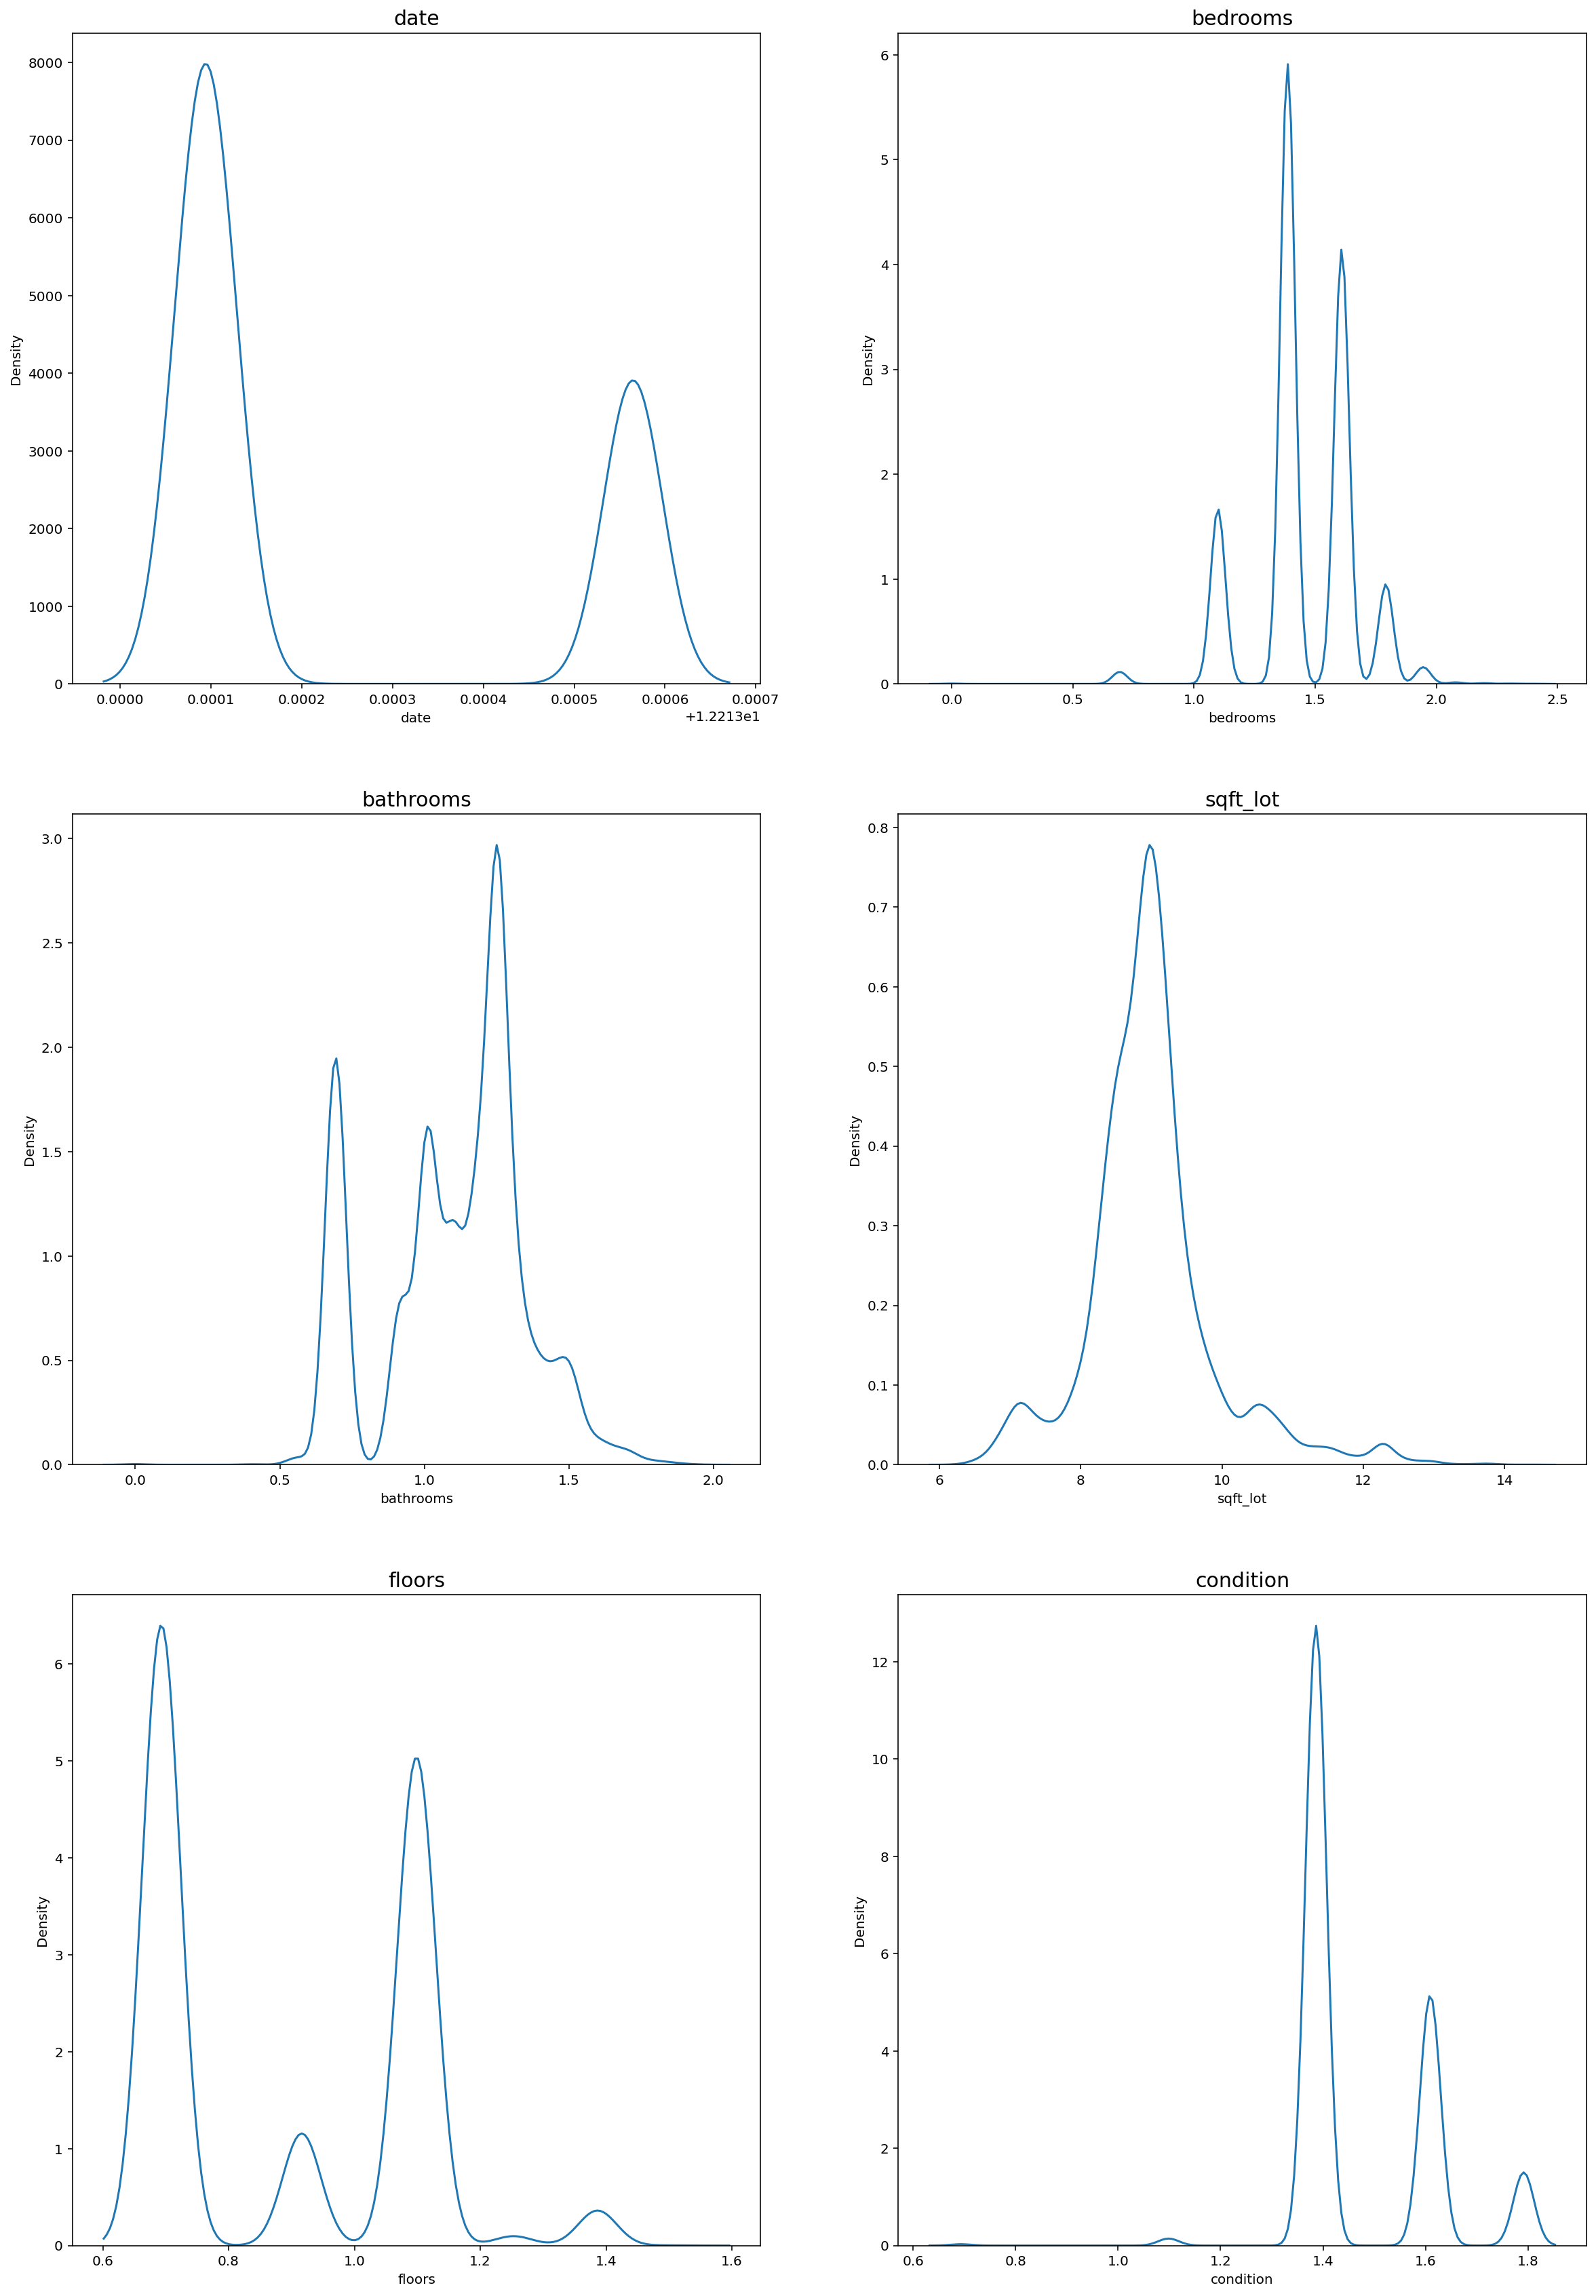

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))

count = 0
for row in range(3):
    for col in range(2):
        if count == 9:
            break
        sns.kdeplot(train_data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [40]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

In [41]:
target_price = train_data['price']
target_price

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15011, dtype: float64

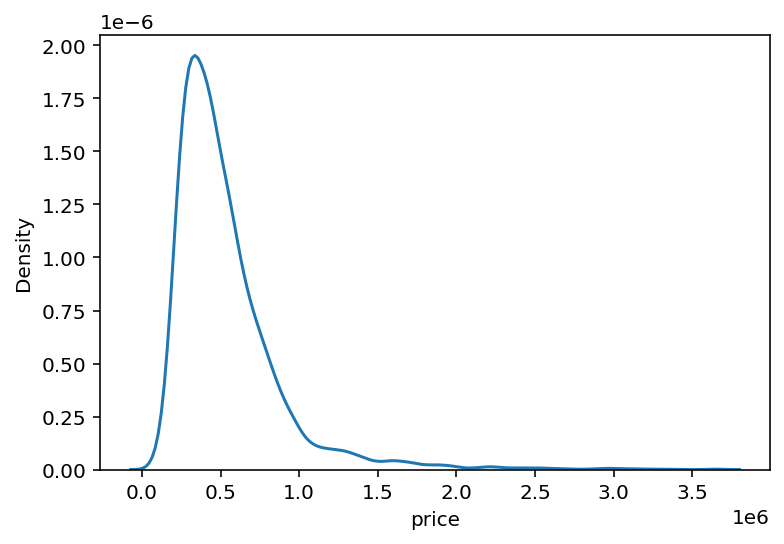

In [42]:
sns.kdeplot(target_price)
plt.show()

In [43]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

           price
0      12.309987
1      12.100718
2      13.142168
3      12.458779
4      12.583999
...          ...
15030  13.322338
15031  13.822984
15032  12.793862
15033  12.899222
15034  12.691584

[15011 rows x 1 columns]


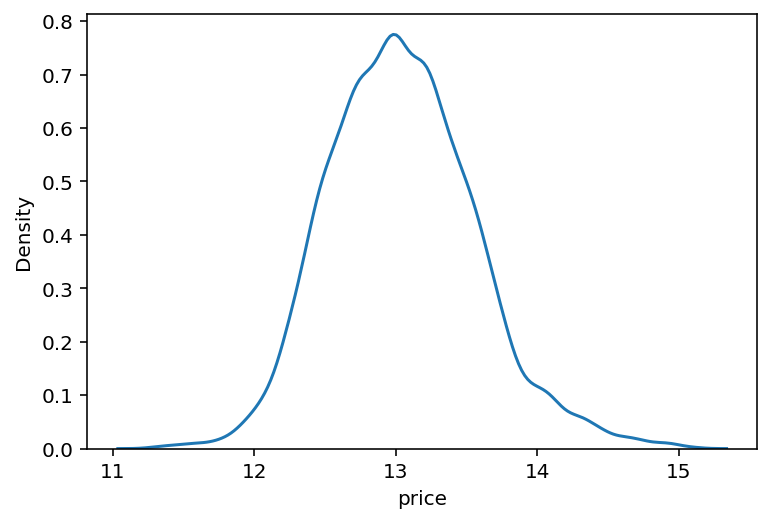

In [44]:
target_price = np.log1p(target_price)
price_plt = pd.DataFrame(target_price)
print(price_plt)
sns.kdeplot(target_price)
plt.show()

In [45]:
train_data

id       date      price  ...     long  sqft_living15  sqft_lot15
0          0  12.213103   221900.0  ... -122.257       7.201171    8.639588
1          1  12.213560   180000.0  ... -122.233       7.908755    8.995041
2          2  12.213560   510000.0  ... -122.045       7.496097    8.923191
3          3  12.213083   257500.0  ... -122.327       7.713785    8.827615
4          4  12.213555   291850.0  ... -122.315       7.409136    9.181118
...      ...        ...        ...  ...      ...            ...         ...
15030  15030  12.213103   610685.0  ... -122.167       7.832411    8.703507
15031  15031  12.213565  1007500.0  ... -122.398       7.626083    8.732466
15032  15032  12.213078   360000.0  ... -122.346       7.333676    7.319865
15033  15033  12.213560   400000.0  ... -122.362       7.512618    8.881975
15034  15034  12.213103   325000.0  ... -122.299       6.928538    7.213768

[15011 rows x 21 columns]

In [46]:
train_len = len(train_data)
sub_id = train_data['id'][train_len:]

del train_data['price']
del train_data['id']
del sub_data['id']

In [47]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

In [48]:
sum_data = pd.concat((train_data, sub_data), axis=0)
sum_data

date  bedrooms  bathrooms  ...     long  sqft_living15    sqft_lot15
0         12.213103  1.386294   0.693147  ... -122.257       7.201171      8.639588
1         12.213560  1.098612   0.693147  ... -122.233       7.908755      8.995041
2         12.213560  1.386294   1.098612  ... -122.045       7.496097      8.923191
3         12.213083  1.386294   1.178655  ... -122.327       7.713785      8.827615
4         12.213555  1.386294   0.916291  ... -122.315       7.409136      9.181118
...             ...       ...        ...  ...      ...            ...           ...
6463  201406.000000  3.000000   1.750000  ... -122.002    1320.000000  11303.000000
6464  201501.000000  3.000000   2.000000  ... -122.288    1400.000000   1230.000000
6465  201502.000000  3.000000   2.500000  ... -122.409    1330.000000   1265.000000
6466  201406.000000  2.000000   0.750000  ... -122.299    1020.000000   2007.000000
6467  201501.000000  3.000000   2.500000  ... -122.069    1410.000000   1287.000000

[21479 rows x 19 columns]

In [49]:
train_data['long']

0       -122.257
1       -122.233
2       -122.045
3       -122.327
4       -122.315
          ...   
15030   -122.167
15031   -122.398
15032   -122.346
15033   -122.362
15034   -122.299
Name: long, Length: 15011, dtype: float64

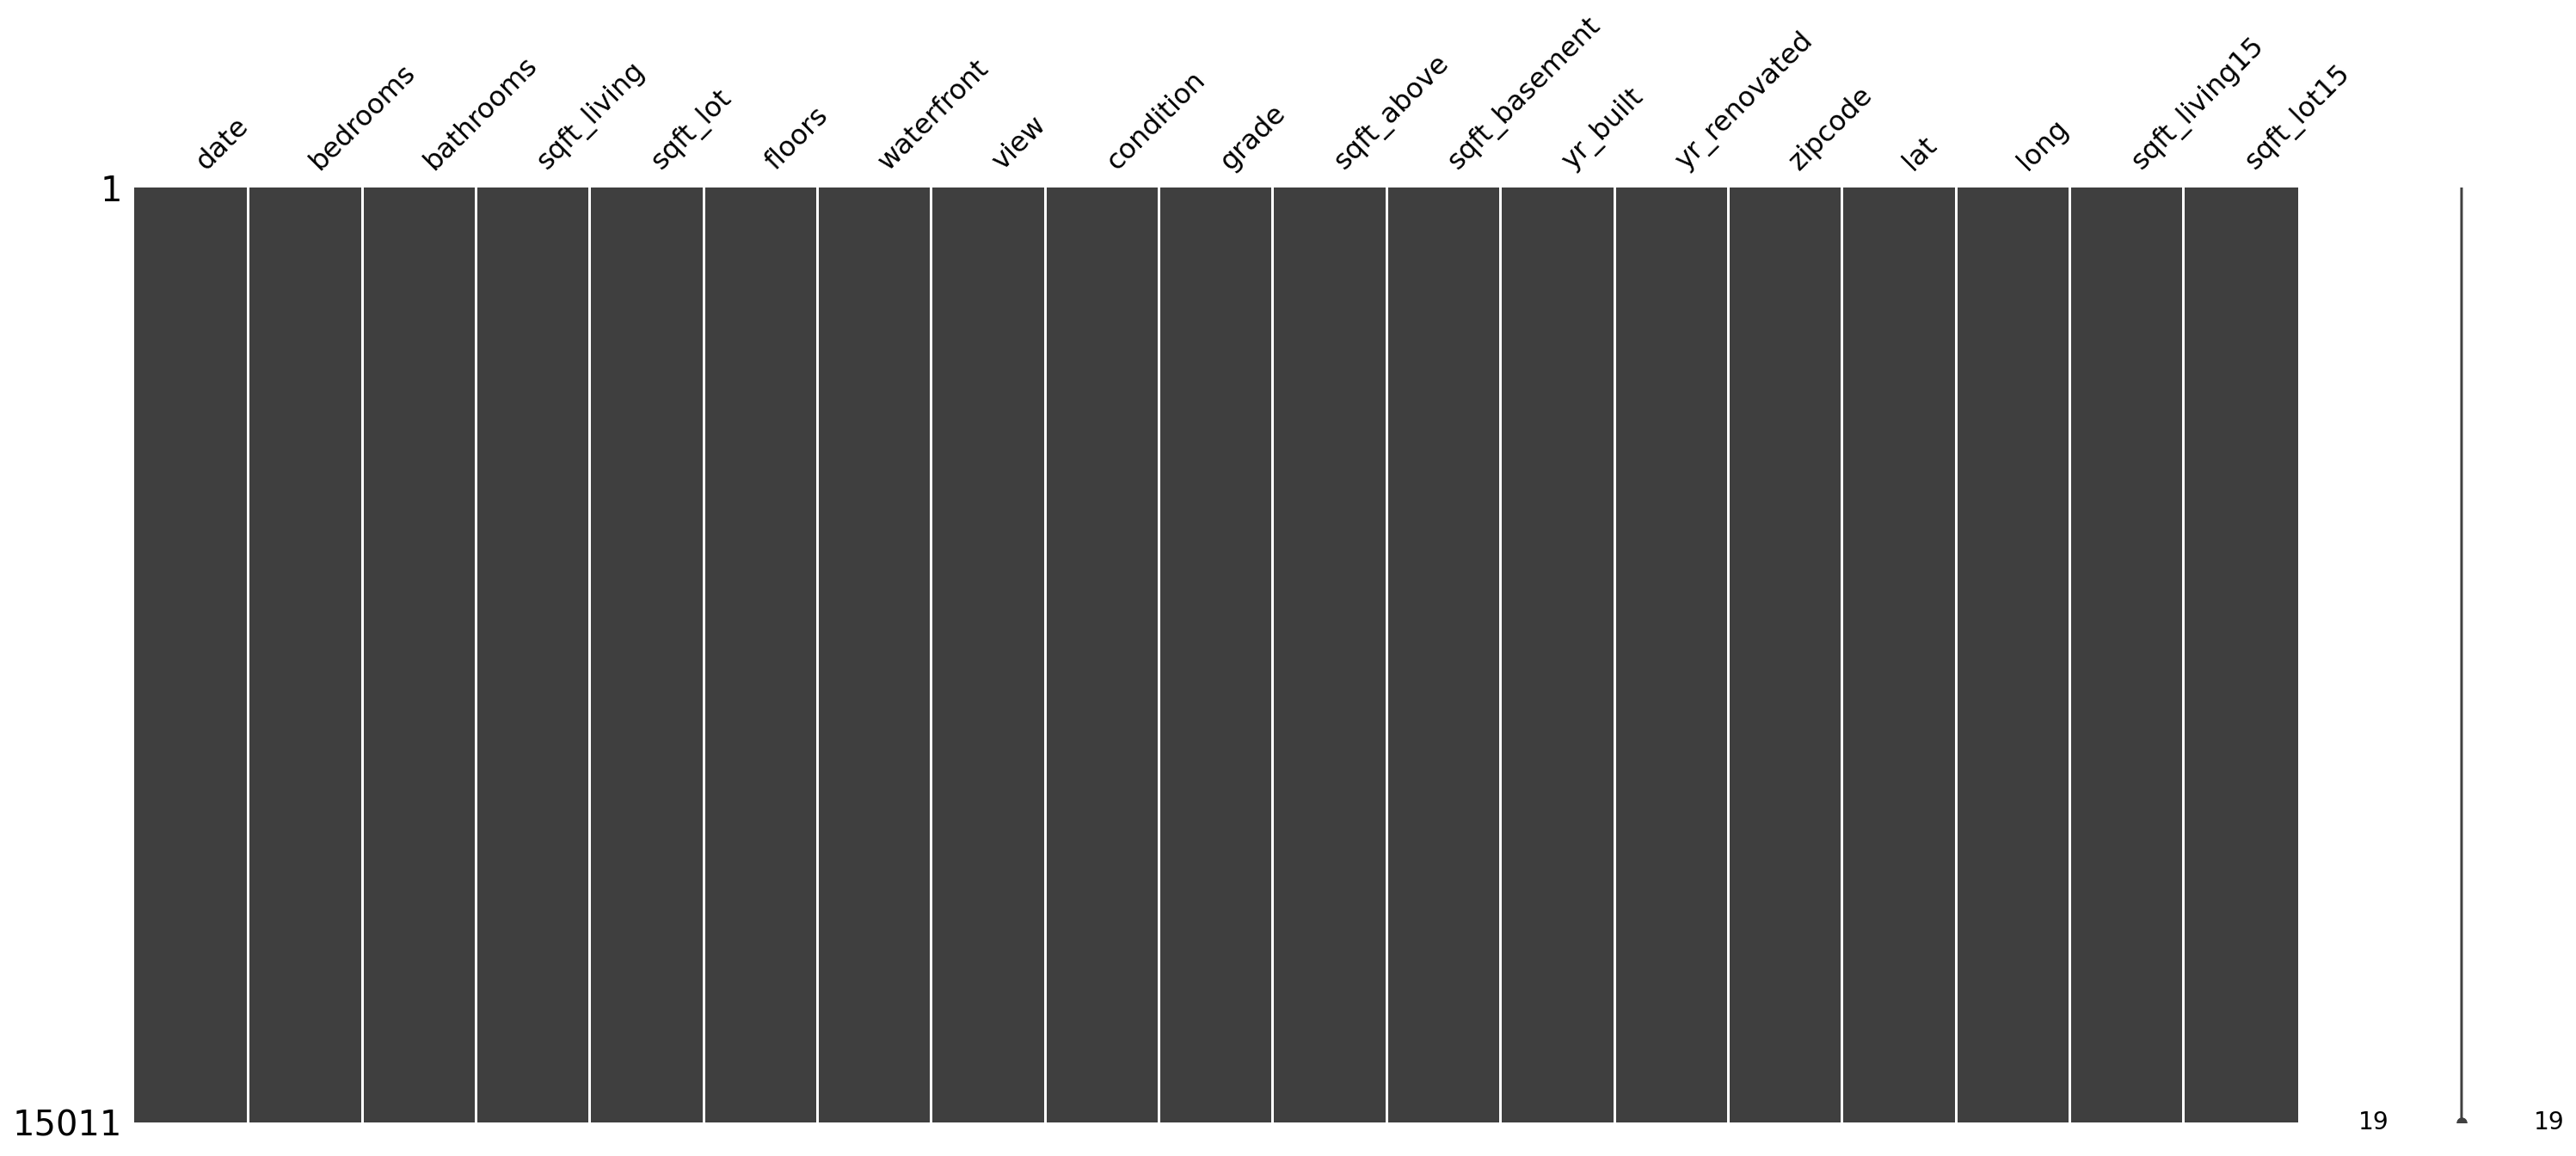

In [55]:
msno.matrix(train_data)

In [56]:
for c in sum_data.columns:
  print('{}: {}'.format(c, len(sum_data.loc[pd.isnull(sum_data[c]), c].values)))
  

date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


In [57]:
# train_data['lat_long'] = train_data.apply(lambda i : (i.lat) + ', ' + (i.long), axis=1)

In [66]:
sub = sum_data.iloc[train_len:, :]
train = sum_data.iloc[:train_len, :]

print(f'1. train_len      : {train_len}')
print(f'2. 학습 데이터 x  : {x.shape}')
print(f'3. 추론 데이터 sub: {sub.shape}')

1. train_len      : 15011
2. 학습 데이터 x  : (15011, 19)
3. 추론 데이터 sub: (6468, 19)


In [59]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

In [60]:
target_price

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15011, dtype: float64

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [62]:
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))

In [63]:
random_state = 200 # random_state 값 고정

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(objective='reg:squarederror',random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

four_models = [gboost, xgboost, lightgbm, rdforest]

In [64]:
target_price

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15011, dtype: float64

In [67]:
def get_scores(four_models, train_data, target_price):
  df = {}

  for model in four_models:
      model_name = model.__class__.__name__ # 모델 이름 획득
      X_train, X_test, y_train, y_test = train_test_split(train_data, target_price, random_state=random_state, test_size=0.2) # train, test 데이터셋 분리 - 여기에도 random_state를 고정
      model.fit(X_train, y_train) # 모델 학습
      y_pred = model.predict(X_test) # 예측
      df[model_name] = rmse(y_test, y_pred) # 예측 결과의 rmse값 저장
      score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) # data frame에 저장
      
  return score_df

get_scores(four_models, train, target_price)

RMSE
XGBRegressor               124262.307087
RandomForestRegressor      124023.861169
GradientBoostingRegressor  121905.617816
LGBMRegressor              105961.134460

In [68]:
from sklearn.model_selection import GridSearchCV

In [73]:
from enum import auto
# param_grid에 탐색할 xgboost관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [1, 10, 15],
    'learning_rate': [0.005, 0.01],
    'num_leaves': [1, 5, 7, 9]
}

In [74]:
# 모델 준비 - 모델은 LightGBM(lgbm) 사용
model = LGBMRegressor(random_state=random_state)

In [75]:
gride_model = GridSearchCV(model, param_grid=param_grid, # -----(1)
                           scoring='neg_mean_squared_error', # -----(2)
                           cv=5, # -----(3)
                           verbose=1, # -----(4)
                           n_jobs=5) # -----(5)
gride_model.fit(train, target_price)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=200), n_jobs=5,
             param_grid={'learning_rate': [0.005, 0.01],
                         'max_depth': [1, 10, 15],
                         'n_estimators': [500, 1000, 1500],
                         'num_leaves': [1, 5, 7, 9]},
             scoring='neg_mean_squared_error', verbose=1)

In [82]:
def my_GridSearch(model, read_train_data, target_price, param_grid, verbose=2, n_jobs=5):
  # grideSearchCV 모델로 초기화
  gride_model = GridSearchCV(model, 
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             verbose=verbose,
                             n_jobs=n_jobs)
  
  gride_model.fit(read_train_data, target_price) # 모델 fitting

  # 결과값 저장
  params = gride_model.cv_results_['params']
  socre = gride_model.cv_results_['mean_test_score']

  # 데이터 프레임 생성
  results = pd.DataFrame(params)
  results['score'] = socre

  # RMSLE 계산 후 정렬
  results["RMSLE"] = np.sqrt(-1 * results['score'])
  results = results.sort_values('RMSLE')

  return results

In [83]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [1, 10, 15],
    'learning_rate': [0.005, 0.01],
    'num_leaves': [1, 5, 7, 9]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, target_price, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


learning_rate  max_depth  n_estimators  num_leaves     score     RMSLE
71           0.01         15          1500           9 -0.028621  0.169177
59           0.01         10          1500           9 -0.028621  0.169177
58           0.01         10          1500           7 -0.029886  0.172876
70           0.01         15          1500           7 -0.029886  0.172876
67           0.01         15          1000           9 -0.030220  0.173840
..            ...        ...           ...         ...       ...       ...
52           0.01         10          1000           1       NaN       NaN
56           0.01         10          1500           1       NaN       NaN
60           0.01         15           500           1       NaN       NaN
64           0.01         15          1000           1       NaN       NaN
68           0.01         15          1500           1       NaN       NaN

[72 rows x 6 columns]

In [85]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, target_price)
prediction = model.predict(train)
prediction

array([12.28573471, 12.40878549, 13.10938247, ..., 12.93263247,
       13.01813479, 12.66509422])

In [86]:
prediction = np.expm1(prediction)
prediction

array([216583.21033045, 244943.14574559, 493550.49279349, ...,
       413589.84450495, 450508.65462489, 316503.97028297])

In [99]:
data_dir = '/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [98]:
# submission['price'] = prediction
# submission

In [105]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'jeong', rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

save_submission(model, train, target_price, sub, 'lgbm', rmsle='0.0168')

/content/drive/MyDrive/AIFFEL/kaggle-kakr-housing-data/data/submission_jeong_RMSLE_0.0168.csv saved!
